# Tesis Magíster Economía: Trabajo de Datos MINSAL

### Trabajo de Datos, Alejo Eyzaguirre

En lo siguiente se trabajarán los datos del DEIS de Atenciones en Urgencia. De esta manera se espera ver un efecto en las atenciones tipo "salud mental" el día del apagón. 

Primero que nada importamos librerías a utilizar:

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, neighbors, decomposition, manifold
from sklearn.preprocessing import LabelEncoder

Hacemos el puente con mi sesión de Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Datos de Urgencia:

Importamos datos de Ingreso a Urgencia (2021). En esta base de datos la unidad de observación corresponde a el Nº de Ingresos a Urgencia en cada Hospital del País, por cada Causa y por cada Día del año 2021.

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Universidad/Proposal Tópicos/AtencionesUrgencia2021.csv', sep = ';', encoding='latin-1')

Analizamos datos rápidamente:

In [ ]:
data.head()

,idestablecimiento,nestablecimiento,idcausa,glosacausa,col01,col02,col03,col04,col05,col06,fecha,semana,glosatipoestablecimiento,glosatipoatencion,glosatipocampana
0,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),1,0,0,0,1,0,06/03/2019,10,SAPU,Indiferenciado,Ninguna
1,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),3,0,0,1,2,0,07/03/2019,10,SAPU,Indiferenciado,Ninguna
2,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),2,0,1,0,1,0,08/03/2019,10,SAPU,Indiferenciado,Ninguna
3,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),3,0,1,0,2,0,09/03/2019,10,SAPU,Indiferenciado,Ninguna
4,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),4,0,0,1,3,0,10/03/2019,11,SAPU,Indiferenciado,Ninguna


In [ ]:
data.shape

(4550877, 15)

In [ ]:
data.describe()

,idcausa,col01,col02,col03,col04,col05,col06,semana
count,4.550877e+06,4.550877e+06,4.550877e+06,4.550877e+06,4.550877e+06,4.550877e+06,4.550877e+06,4.550877e+06
mean,1.481481e+01,9.772512e+00,4.033853e-01,1.175460e+00,1.612043e+00,5.296896e+00,1.284728e+00,2.638158e+01
std,8.326830e+00,2.988799e+01,1.974776e+00,4.377787e+00,6.026103e+00,1.679092e+01,4.562772e+00,1.500762e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01
50%,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01
75%,2.200000e+01,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,3.900000e+01
max,2.900000e+01,1.152000e+03,3.020000e+02,1.980000e+02,3.840000e+02,6.060000e+02,2.910000e+02,5.200000e+01


Establecemos la columna fecha como formato "fecha". De esta manera será más fácil identificar posteriormente las semanas y días de interés.

In [ ]:
data['fecha'] = pd.to_datetime(data['fecha'])


Ordenamos la Base de Datos según la fecha de cada observación:

In [ ]:
data.sort_values('fecha')

,idestablecimiento,nestablecimiento,idcausa,glosacausa,col01,col02,col03,col04,col05,col06,fecha,semana,glosatipoestablecimiento,glosatipoatencion,glosatipocampana
1469819,15-113,Hospital de Lolol,3,Bronquitis/bronquiolitis aguda (J20-J21),0,0,0,0,0,0,2019-01-01,1,Hospital,Indiferenciado,Ninguna
1373459,19-801,SAR Hualpencillo,5,NeumonÃ­a (J12-J18),0,0,0,0,0,0,2019-01-01,1,SAR,Indiferenciado,Ninguna
1416939,17-824,SAPU-Los Volcanes,19,Accidentes del trÃ¡nsito,0,0,0,0,0,0,2019-01-01,1,SAPU,Indiferenciado,Ninguna
2137537,02-807,SAPU-Alto Hospicio - La Pampa,19,Accidentes del trÃ¡nsito,0,0,0,0,0,0,2019-01-01,1,SAPU,Indiferenciado,Ninguna
2593217,11-302,Consultorio Los Nogales,3,Bronquitis/bronquiolitis aguda (J20-J21),2,0,0,0,1,1,2019-01-01,1,SAPU,Indiferenciado,Ninguna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609563,09-821,SAPU-Juan Antonio Rios,25,SECCIÃN 2. TOTAL DE HOSPITALIZACIONES,0,0,0,0,0,0,2019-12-31,1,SAPU,Indiferenciado,Ninguna
806368,28-112,Hospital de Contulmo,8,Â - LAS DEMÃS CAUSAS,0,0,0,0,0,0,2019-12-31,1,Hospital,Indiferenciado,Ninguna
999830,15-803,SAPU-Maria Latiffe,11,Crisis obstructiva bronquial (J40-J46),0,0,0,0,0,0,2019-12-31,1,SAPU,Indiferenciado,Ninguna
856396,05-805,SAR Tierras Blancas,18,TOTAL TRAUMATISMOS Y ENVENENAMIENTO,23,0,1,7,13,2,2019-12-31,1,SAR,Indiferenciado,Ninguna


In [ ]:
data.columns

Index(['idestablecimiento', 'nestablecimiento', 'idcausa', 'glosacausa',
       'col01', 'col02', 'col03', 'col04', 'col05', 'col06', 'fecha', 'semana',
       'glosatipoestablecimiento', 'glosatipoatencion', 'glosatipocampana'],
      dtype='object')

## Base de Hospitales y Establecimientos 

De esta manera podemos encontrar la comuna a la cuál pertenece el Hospital. La importamos previamente pero la utilizaremos posteriormente. No hacemos el merge en un principio porque al hacerlo se consume toda la RAM. Por ello haremos merge solamente a la base "más limpia" más adelante.

In [ ]:
hospitals = pd.read_excel('/content/gdrive/MyDrive/Universidad/Tesis/hospitals.xlsx')

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:211: UserWarning: Cell U4134 is marked as a date but the serial value 973784866 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
hospitals.head()

,idestablecimiento,Código Vigente,Código Madre,Código Nuevo Madre,Código Región,Nombre Región,Código Dependencia Jerárquica (SEREMI / Servicio de Salud),Nombre Dependencia Jerárquica (SEREMI / Servicio de Salud),Pertenencia al SNSS,Tipo Establecimiento,Ámbito de Funcionamiento,Nombre Oficial,Certificación,Dependencia Administrativa,Nivel de Atención,Código Comuna,Nombre Comuna,Vía,Número,Dirección,Teléfono,Fecha Inicio Funcionamiento,Tiene Servicio de Urgencia,Tipo de Urgencia,Tipo de SAPU,LATITUD [Grados decimales],LONGITUD [Grados decimales],Tipo de Prestador Sistema de Salud,Estado de Funcionamiento,Nivel de Complejidad,Modalidad de Atención,Fecha de Incorporación a la base o cambios,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,No Aplica,200691,No Aplica,No Aplica,12,Región De Magallanes y de la Antártica Chilena,No Aplica,No Aplica,No Aplica,Servicio Médico Legal,Establecimiento Medicina Legal,Servicio Médico Legal Punta Arenas,No Aplica,Ministerio de Justicia,No Aplica,12101,Punta Arenas,Calle,170,Lautaro Navarro,(61)247011,Sin dato,NO,No Aplica,No Aplica,-53.155017,-70.897351,Institución Medicina Legal,Vigente en operación,No Aplica,No Aplica,NaN,NaN,NaN,NaN
1,No Aplica,200692,No Aplica,No Aplica,12,Región De Magallanes y de la Antártica Chilena,No Aplica,No Aplica,No Aplica,Servicio Médico Legal,Establecimiento Medicina Legal,Servicio Médico Legal Puerto Natales,No Aplica,Ministerio de Justicia,No Aplica,12401,Natales,Avenida,1710,Carlos Ibáñez,(61)415865,Sin dato,NO,No Aplica,No Aplica,-51.738674,-72.490569,Institución Medicina Legal,Vigente en operación,No Aplica,No Aplica,NaN,NaN,NaN,NaN
2,No Aplica,200689,No Aplica,No Aplica,11,Región De Aysén del General Carlos Ibañez del ...,No Aplica,No Aplica,No Aplica,Servicio Médico Legal,Establecimiento Medicina Legal,Servicio Médico Legal Coyhaique,No Aplica,Ministerio de Justicia,No Aplica,11101,Coyhaique,Calle,288,"12 de Octubre, Oficina 206 - 207",(67)236309 - 236310,Sin dato,NO,No Aplica,No Aplica,-45.571887,-72.071963,Institución Medicina Legal,Vigente en operación,No Aplica,No Aplica,NaN,NaN,NaN,NaN
3,No Aplica,200690,No Aplica,No Aplica,11,Región De Aysén del General Carlos Ibañez del ...,No Aplica,No Aplica,No Aplica,Servicio Médico Legal,Establecimiento Medicina Legal,Servicio Médico Legal Puerto Aysén,No Aplica,Ministerio de Justicia,No Aplica,11201,Aisén,Calle,S/N,"Circunvalación Rivera Sur, Edificio de Servici...",(67)336305,Sin dato,NO,No Aplica,No Aplica,-45.406642,-72.696557,Institución Medicina Legal,Vigente en operación,No Aplica,No Aplica,NaN,NaN,NaN,NaN
4,No Aplica,200688,No Aplica,No Aplica,10,Región De Los Lagos,No Aplica,No Aplica,No Aplica,Servicio Médico Legal,Establecimiento Medicina Legal,Servicio Médico Legal Ancud,No Aplica,Ministerio de Justicia,No Aplica,10202,Ancud,Calle,74,"Cerro, Villa Las Araucarias",(65)2627077,Sin dato,NO,No Aplica,No Aplica,-41.866896,-73.813994,Institución Medicina Legal,Vigente en operación,No Aplica,No Aplica,NaN,NaN,NaN,NaN


In [ ]:
hosp_merge = hospitals[['idestablecimiento','Nombre Oficial','Código Comuna','Nombre Comuna','Código Región']]

In [ ]:
data_merge = data.drop(['GLOSATIPOESTABLECIMIENTO', 'GLOSATIPOATENCION','GlosaTipoCampana'], axis=1)

In [ ]:
oficial = pd.merge(data_merge, hosp_merge, how="inner", on=["idestablecimiento"])

In [ ]:
oficial.sort_values('fecha')

,idestablecimiento,nestablecimiento,idcausa,glosacausa,col01,col02,col03,col04,col05,col06,fecha,semana,Nombre Oficial,Código Comuna,Nombre Comuna,Código Región
2727541,22-306,Consultorio Juan Santa MarÃ­a Bonet,21,TOTAL DEMÃS CAUSAS,15,0,0,2,10,3,2019-01-01,1,Centro de Salud Familiar Juan Santa María Bonet,14203,Lago Ranco,14
3813432,05-103,Hospital Dr. Humberto Elorza CortÃ©z (Illapel),19,Accidentes del trÃ¡nsito,0,0,0,0,0,0,2019-01-01,1,Hospital Dr. Humberto Elorza Cortés (Illapel),04201,Illapel,4
3571721,21-347,Centro de Salud Familiar Pedro de Valdivia (Te...,16,Arritmia grave,0,0,0,0,0,0,2019-01-01,1,Centro de Salud Familiar Pedro de Valdivia,09101,Temuco,9
906539,13-806,SAPU-La Feria,2,TOTAL CAUSAS SISTEMA RESPIRATORIO,22,0,3,3,11,5,2019-01-01,1,SAPU La Feria,13121,Pedro Aguirre Cerda,13
3813382,05-103,Hospital Dr. Humberto Elorza CortÃ©z (Illapel),13,Infarto agudo miocardio,0,0,0,0,0,0,2019-01-01,1,Hospital Dr. Humberto Elorza Cortés (Illapel),04201,Illapel,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854983,15-106,Hospital de Pichidegua,4,Influenza (J09-J11),0,0,0,0,0,0,2019-12-31,1,Hospital de Pichidegua,06113,Pichidegua,6
257279,16-813,SAR San Clemente,15,Crisis hipertensiva,0,0,0,0,0,0,2019-12-31,1,SAR San Clemente,07109,San Clemente,7
2865318,22-103,Hospital de Lanco,6,"Otra causa respiratoria (J22, J30-J39, J47, J6...",0,0,0,0,0,0,2019-12-31,1,Hospital de Lanco,14103,Lanco,14
20324,13-831,SAPU- Edgardo Enriquez Froedden,29,DIARREA AGUDA (A00-A09),3,0,1,1,0,1,2019-12-31,1,SAPU Edgardo Enríquez Froedden,13121,Pedro Aguirre Cerda,13


In [ ]:
def saca_dia(datetime):
  '''Saca día de datetime'''
  dia = datetime.day
  return dia

def saca_mes(datetime):
  '''Saca mes de datetime'''
  mes = datetime.month
  return mes

def saca_ano(datetime):
  '''Saca año de datetime'''
  ano = datetime.year
  return ano

In [ ]:
oficial['dia'] = oficial['fecha'].apply(saca_dia)
oficial['mes'] = oficial['fecha'].apply(saca_mes)
oficial['ano'] = oficial['fecha'].apply(saca_ano)

In [ ]:
oficial

,idestablecimiento,nestablecimiento,idcausa,glosacausa,col01,col02,col03,col04,col05,col06,fecha,semana,Nombre Oficial,Código Comuna,Nombre Comuna,Código Región,dia,mes,ano
0,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),1,0,0,0,1,0,2019-06-03,10,SAPU Karol Wojtyla,13201,Puente Alto,13,3,6,2019
1,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),3,0,0,1,2,0,2019-07-03,10,SAPU Karol Wojtyla,13201,Puente Alto,13,3,7,2019
2,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),2,0,1,0,1,0,2019-08-03,10,SAPU Karol Wojtyla,13201,Puente Alto,13,3,8,2019
3,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),3,0,1,0,2,0,2019-09-03,10,SAPU Karol Wojtyla,13201,Puente Alto,13,3,9,2019
4,14-826,SAPU Karol Wojtyla,3,Bronquitis/bronquiolitis aguda (J20-J21),4,0,0,1,3,0,2019-10-03,11,SAPU Karol Wojtyla,13201,Puente Alto,13,3,10,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393165,01-303,Centro de Salud Familiar Iris VÃ©liz Hume (Ex ...,23,Â - TRAUMATISMOS Y ENVENENAMIENTOS,0,0,0,0,0,0,2019-07-01,2,Centro de Salud Familiar E.U. Iris Veliz Hume ...,15101,Arica,15,1,7,2019
4393166,01-303,Centro de Salud Familiar Iris VÃ©liz Hume (Ex ...,23,Â - TRAUMATISMOS Y ENVENENAMIENTOS,0,0,0,0,0,0,2019-08-01,2,Centro de Salud Familiar E.U. Iris Veliz Hume ...,15101,Arica,15,1,8,2019
4393167,01-303,Centro de Salud Familiar Iris VÃ©liz Hume (Ex ...,27,Pacientes en espera de hospitalizaciÃ³n,0,0,0,0,0,0,2019-06-01,2,Centro de Salud Familiar E.U. Iris Veliz Hume ...,15101,Arica,15,1,6,2019
4393168,01-303,Centro de Salud Familiar Iris VÃ©liz Hume (Ex ...,27,Pacientes en espera de hospitalizaciÃ³n,0,0,0,0,0,0,2019-07-01,2,Centro de Salud Familiar E.U. Iris Veliz Hume ...,15101,Arica,15,1,7,2019


In [ ]:
compression_opts = dict(method='zip', archive_name='emergencies.csv')
oficial.to_csv('emergencies.zip', index=False, compression=compression_opts)

## Analizando Datos Semana Outage y Otras Semanas

Creamos subset de datos en otro DataFrame con la semana de interés (semana 40 del 2021).

In [ ]:
semana = data[data['semana'] == 40]

In [ ]:
semana.head()

,idestablecimiento,nestablecimiento,Idcausa,glosacausa,TOTAL,MENOR_A_1,Column7,__14,_5_64,_5_MAS,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
37441,29-901,SAR Victoria,17,Otras causas circulatorias,0,0,0,0,0,0,2021-10-03 00:00:00+04:00,40,SAR,Indiferenciado,Ninguna
37442,29-901,SAR Victoria,17,Otras causas circulatorias,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SAR,Indiferenciado,Ninguna
37443,29-901,SAR Victoria,17,Otras causas circulatorias,0,0,0,0,0,0,2021-10-05 00:00:00+04:00,40,SAR,Indiferenciado,Ninguna
37444,29-901,SAR Victoria,17,Otras causas circulatorias,0,0,0,0,0,0,2021-10-06 00:00:00+04:00,40,SAR,Indiferenciado,Ninguna
37445,29-901,SAR Victoria,17,Otras causas circulatorias,0,0,0,0,0,0,2021-10-07 00:00:00+04:00,40,SAR,Indiferenciado,Ninguna


In [ ]:
semana.shape

(168720, 15)

In [ ]:
semana = semana.sort_values('fecha')

A modo de identificar las causas asociadas a Salud Mental se imprimen todas aquellas causas de ingreso a urgencia para identificar cual de todas ellas corresponde a las de salud mental.

In [ ]:
semana['glosacausa'].unique()

array(['Otras causas circulatorias', 'IRA Alta (J00-J06)',
       'Otros trastornos mentales no contenidos en las categorías anteriores',
       'Otras causas externas',
       'Otra causa respiratoria (J22, J30-J39, J47, J60-J98)',
       'Infarto agudo miocardio',
       'Trastornos del Humor (Afectivos) (F30-F39)',
       'Crisis obstructiva bronquial (J40-J46)',
       'Accidente vascular encefálico', 'Ideación Suicida (R45.8)',
       'TOTAL CAUSAS SISTEMA CIRCULATORIO',
       '\xa0- TRAUMATISMOS Y ENVENENAMIENTOS', 'Arritmia grave',
       'Influenza (J09-J11)', 'TOTAL DEMÁS CAUSAS',
       ' - COVID 19 SOSPECHOSO (U07.2)',
       'Pacientes en espera de hospitalización que esperan menos de 12 horas para ser trasladados a cama hospitalaria',
       'CIRUGÍAS DE URGENCIA', 'DIARREA AGUDA (A00-A09)',
       'TOTAL TRAUMATISMOS Y ENVENENAMIENTO',
       '\xa0-\xa0CAUSAS SISTEMA CIRCULATORIO',
       'Trastornos mentales y del comportamiento debidos al uso de sustancias psicoactivas

In [ ]:
semana['Idcausa'].unique()

array([17, 10, 41, 20,  6, 13, 39, 11, 14, 37, 12, 23, 16,  4, 21, 33, 28,
       24, 29, 18, 22, 38, 31, 34,  7, 27, 25, 35,  8,  3, 42,  1, 40, 36,
       19,  5, 32,  2, 15, 30])

Nos quedamos con:
 41, 39, 37, 38, 35, 42 y 40.

1.   CAUSAS POR TRASTORNOS MENTALES (F00-F99) --> 41
2.   Ideación Suicida (R45.8) --> 39
3.   Lesiones autoinfligidas intencionalmente (X60-X84) --> 37
4.   Otros trastornos mentales no contenidos en las categorías anteriores --> 38
5. Trastornos del Humor (Afectivos) (F30-F39) --> 35
6. Trastornos mentales y del comportamiento debidos al uso de sustancias psicoactivas (F10-F19) --> 42
7. Trastornos neuróticos, trastornos relacionados con el estrés y trastornos somatomorfos (F40-F48) Incluído el trastorno de pánico (F41.0) --> 40



In [ ]:
# Causas Salud Mental

ids = {41,39,37,38,35,42,40}
type(ids)


set

Creamos entonces nueva base de datos ``mental_health`` que contiene solo las causas asociadas a salud mental de la semana crítica (40).

In [ ]:
mental_health = semana[semana['Idcausa'].isin(ids)]

In [ ]:
mental_health.shape

(29526, 15)

A modo de identificar el día exacto usamos la función ``saca_dia`` que permite extraer el día de cada observación.

In [ ]:
def saca_dia(datetime):
  '''Saca día de datetime'''
  dia = datetime.day
  return dia


In [ ]:
mental_health['dia'] = mental_health['fecha'].apply(saca_dia)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
mental_health

,idestablecimiento,nestablecimiento,Idcausa,glosacausa,TOTAL,MENOR_A_1,Column7,__14,_5_64,_5_MAS,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,dia
6677934,02-917,SUR Chanavayita,41,Otros trastornos mentales no contenidos en las...,0,0,0,0,0,0,2021-10-03 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,3
3471475,15-954,SUR de Malloa,39,Trastornos del Humor (Afectivos) (F30-F39),0,0,0,0,0,0,2021-10-03 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,3
5499838,24-900,SAPU Carmela Carvajal,37,Ideación Suicida (R45.8),0,0,0,0,0,0,2021-10-03 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,3
3471387,21-117,Hospital de Pitrufquén ...,37,Ideación Suicida (R45.8),0,0,0,0,0,0,2021-10-03 00:00:00+04:00,40,Hospital,Indiferenciado,Ninguna,3
3472114,03-800,SAPU Norte de Antofagasta,37,Ideación Suicida (R45.8),0,0,0,0,0,0,2021-10-03 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6108937,09-811,SAPU José Bauzá Frau,41,Otros trastornos mentales no contenidos en las...,0,0,0,0,0,0,2021-10-09 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,9
6109679,05-936,SUR La Higuera,39,Trastornos del Humor (Afectivos) (F30-F39),0,0,0,0,0,0,2021-10-09 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,9
6116652,15-929,SAR San Vicente de Tagua Tagua,41,Otros trastornos mentales no contenidos en las...,2,0,0,0,2,0,2021-10-09 00:00:00+04:00,40,SAR,Indiferenciado,Ninguna,9
6116795,16-813,SAR San Clemente,41,Otros trastornos mentales no contenidos en las...,0,0,0,0,0,0,2021-10-09 00:00:00+04:00,40,SAR,Indiferenciado,Ninguna,9


Ahora creamos otra base de datos ``dia_d`` que contiene solo las observaciones del día del apagón (4 de Octubre) para las causas asociadas a salud mental.

In [ ]:
dia_d = mental_health[mental_health['dia'] == 4]

In [ ]:
dia_d

,idestablecimiento,nestablecimiento,Idcausa,glosacausa,TOTAL,MENOR_A_1,Column7,__14,_5_64,_5_MAS,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,dia
5334645,06-829,SAPU Néstor Fernández Thomas,39,Trastornos del Humor (Afectivos) (F30-F39),0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,4
5854071,16-965,SUR Vara Gruesa,37,Ideación Suicida (R45.8),0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,4
7097939,201085,SAPU Aviador Acevedo,38,Trastornos mentales y del comportamiento debid...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,4
5932249,07-800,SAPU Nueva Aurora,40,"Trastornos neuróticos, trastornos relacionados...",5,0,0,0,5,0,2021-10-04 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,4
5206003,15-108,Hospital Mercedes (Chimbarongo) ...,35,Lesiones autoinfligidas intencionalmente (X60-...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,Hospital,Indiferenciado,Ninguna,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6555168,15-110,Hospital de Santa Cruz ...,41,Otros trastornos mentales no contenidos en las...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,Hospital,Indiferenciado,Ninguna,4
7465253,17-920,SUR Pinto,39,Trastornos del Humor (Afectivos) (F30-F39),0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,4
7465244,22-814,SAPU Angachilla,35,Lesiones autoinfligidas intencionalmente (X60-...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,4
7464309,14-824,SAPU Santa Amalia,38,Trastornos mentales y del comportamiento debid...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,4


In [ ]:
dia_d.shape

(4214, 16)

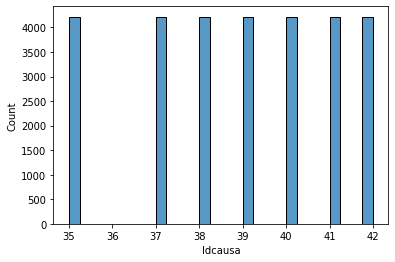

In [ ]:
sns.histplot(data=mental_health, x="Idcausa")

In [ ]:
dia_d['Idcausa'].value_counts()

39    602
37    602
38    602
40    602
35    602
41    602
42    602
Name: Idcausa, dtype: int64

In [ ]:
dia_d.sort_values('nestablecimiento')

,idestablecimiento,nestablecimiento,Idcausa,glosacausa,TOTAL,MENOR_A_1,Column7,__14,_5_64,_5_MAS,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,dia
4992804,02-924,CEAR Camiña,41,Otros trastornos mentales no contenidos en las...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,CEAR,Indiferenciado,Ninguna,4
4991954,02-924,CEAR Camiña,38,Trastornos mentales y del comportamiento debid...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,CEAR,Indiferenciado,Ninguna,4
6578062,02-924,CEAR Camiña,35,Lesiones autoinfligidas intencionalmente (X60-...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,CEAR,Indiferenciado,Ninguna,4
3488459,02-924,CEAR Camiña,40,"Trastornos neuróticos, trastornos relacionados...",0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,CEAR,Indiferenciado,Ninguna,4
3487329,02-924,CEAR Camiña,39,Trastornos del Humor (Afectivos) (F30-F39),0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,CEAR,Indiferenciado,Ninguna,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7137802,07-954,SUR Dr. Johow (Zapallar),37,Ideación Suicida (R45.8),0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,4
7141613,07-954,SUR Dr. Johow (Zapallar),38,Trastornos mentales y del comportamiento debid...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,4
6452438,07-954,SUR Dr. Johow (Zapallar),41,Otros trastornos mentales no contenidos en las...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,4
7138961,07-954,SUR Dr. Johow (Zapallar),39,Trastornos del Humor (Afectivos) (F30-F39),0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,4


Ahora recién haremos merge con la base de datos de establecimientos para así tener la comuna de cada observación. La nueva base de datos sería ``Dia_D``.

In [ ]:
Dia_D = pd.merge(dia_d, hospitals, how="left", on=["idestablecimiento"])

In [ ]:
Dia_D.tail()

,idestablecimiento,nestablecimiento,Idcausa,glosacausa,TOTAL,MENOR_A_1,Column7,__14,_5_64,_5_MAS,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana,dia,Código Vigente,Código Madre,Código Nuevo Madre,Código Región,Nombre Región,Código Dependencia Jerárquica (SEREMI / Servicio de Salud),Nombre Dependencia Jerárquica (SEREMI / Servicio de Salud),Pertenencia al SNSS,Tipo Establecimiento,Ámbito de Funcionamiento,Nombre Oficial,Certificación,Dependencia Administrativa,Nivel de Atención,Código Comuna,Nombre Comuna,Vía,Número,Dirección,Teléfono,Fecha Inicio Funcionamiento,Tiene Servicio de Urgencia,Tipo de Urgencia,Tipo de SAPU,LATITUD [Grados decimales],LONGITUD [Grados decimales],Tipo de Prestador Sistema de Salud,Estado de Funcionamiento,Nivel de Complejidad,Modalidad de Atención,Fecha de Incorporación a la base o cambios,Unnamed: 32,Unnamed: 33,Unnamed: 34
4209,15-110,Hospital de Santa Cruz ...,41,Otros trastornos mentales no contenidos en las...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,Hospital,Indiferenciado,Ninguna,4,115110.0,No Aplica,No Aplica,6.0,Región Del Libertador Gral. B. O'Higgins,15,Servicio de Salud Del Libertador B.O'Higgins,Perteneciente,Hospital,Establecimiento de Salud,Hospital de Santa Cruz,No Aplica,Servicio de Salud,Terciario,06310,Santa Cruz,Avenida,921,Federico Errázuriz,722332273,2009-01-01 00:00:00,SI,Urgencia Hospitalaria (UEH),No Aplica,-34.634422,-71.35723,Público,Vigente en operación,Mediana Complejidad,Atención Cerrada-Hospitalaria,NaN,NaN,NaN,NaN
4210,17-920,SUR Pinto,39,Trastornos del Humor (Afectivos) (F30-F39),0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SUR,Indiferenciado,Ninguna,4,200837.0,17-317,117317,16.0,Región De Ñuble,17,Servicio de Salud Ñuble,Perteneciente,Servicio de Urgencia Rural (SUR),Establecimiento de Salud,SUR Pinto,No Aplica,Municipal,Primario,16106,Pinto,Calle,S/N,Ernesto Riquelme,422484015,Sin dato,SI,Urgencia Ambulatoria (SUR),No Aplica,-36.704575,-71.893164,Público,Vigente en operación,Baja Complejidad,Atención Abierta-Ambulatoria,NaN,NaN,NaN,NaN
4211,22-814,SAPU Angachilla,35,Lesiones autoinfligidas intencionalmente (X60-...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,4,122814.0,22-314,122314,14.0,Región De Los Ríos,22,Servicio de Salud Valdivia,Perteneciente,Servicio de Atención Primaria de Urgencia (SAPU),Establecimiento de Salud,SAPU Angachilla,No Aplica,Municipal,Primario,14101,Valdivia,Calle,3821,Santa Martina,632220316,2009-01-01 00:00:00,SI,Urgencia Ambulatoria (SAPU),Corto,-39.849958,-73.223185,Público,Vigente en operación,Baja Complejidad,Atención Abierta-Ambulatoria,NaN,NaN,NaN,NaN
4212,14-824,SAPU Santa Amalia,38,Trastornos mentales y del comportamiento debid...,0,0,0,0,0,0,2021-10-04 00:00:00+04:00,40,SAPU,Indiferenciado,Ninguna,4,114824.0,14-324,114324,13.0,Región Metropolitana de Santiago,14,Servicio de Salud Metropolitano Sur Oriente,Perteneciente,Servicio de Atención Primaria de Urgencia (SAPU),Establecimiento de Salud,SAPU Santa Amalia,No Aplica,Municipal,Primario,13110,La Florida,Calle,202,Santa Amalia,222816173,2009-01-01 00:00:00,SI,Urgencia Ambulatoria (SAPU),Corto,-33.543587,-70.592865,Público,Vigente en operación,Baja Complejidad,Atención Abierta-Ambulatoria,NaN,NaN,NaN,NaN
4213,19-100,Hospital Las Higueras (Talcahuano) ...,38,Trastornos mentales y del comportamiento debid...,2,0,0,0,2,0,2021-10-04 00:00:00+04:00,40,Hospital,Indiferenciado,Ninguna,4,119100.0,No Aplica,No Aplica,8.0,Región Del Bíobío,19,Servicio de Salud Talcahuano,Perteneciente,Hospital,Establecimiento de Salud,Hospital Las Higueras (Talcahuano),Autogestionado en Red ( EAR),Servicio de Salud,Terciario,08110,Talcahuano,Calle,777,Alto Horno,412687000,2009-01-01 00:00:00,SI,Urgencia Hospitalaria (UEH),No Aplica,-36.740101,-73.108694,Público,Vigente en operación,Alta Complejidad,Atención Cerrada-Hospitalaria,NaN,NaN,NaN,NaN


In [ ]:
Dia_D.shape

(4214, 50)

Generamos una tablita que acople por comuna. Nueva unidad de observación será el número de ingresos a urgencia en cada comuna en el día del apagón, por cada una de las causas de Salud Mental.

In [ ]:
mid = Dia_D.pivot_table(index = 'Código Comuna', columns='Idcausa', aggfunc={'TOTAL':sum})

In [ ]:
mid.head()

TOTAL                  
Idcausa          35 37 38 39 40 41 42
Código Comuna                        
10202             0  0  0  0  0  0  0
10203             0  0  0  0  0  0  0
10205             0  0  0  0  0  0  0
10206             0  0  0  0  0  0  0
10209             0  0  0  0  0  0  0

In [ ]:
mid['TOTAL'].head()

Idcausa,35,37,38,39,40,41,42
Código Comuna,,,,,,,
10202,0,0,0,0,0,0,0
10203,0,0,0,0,0,0,0
10205,0,0,0,0,0,0,0
10206,0,0,0,0,0,0,0
10209,0,0,0,0,0,0,0


In [ ]:
mid2 = mid.reset_index()

In [ ]:
mid2.head()

Código Comuna TOTAL                  
Idcausa                  35 37 38 39 40 41 42
0               10202     0  0  0  0  0  0  0
1               10203     0  0  0  0  0  0  0
2               10205     0  0  0  0  0  0  0
3               10206     0  0  0  0  0  0  0
4               10209     0  0  0  0  0  0  0

In [ ]:
formap = mid2['TOTAL']

In [ ]:
formap['cod_comuna'] = mid2['Código Comuna']

In [ ]:
formap.head()

Idcausa,35,37,38,39,40,41,42,cod_comuna
0,0,0,0,0,0,0,0,10202
1,0,0,0,0,0,0,0,10203
2,0,0,0,0,0,0,0,10205
3,0,0,0,0,0,0,0,10206
4,0,0,0,0,0,0,0,10209


In [ ]:
formap.shape

(302, 8)

In [ ]:
formap

Idcausa,35,37,38,39,40,41,42,cod_comuna
0,0,0,0,0,0,0,0,10202
1,0,0,0,0,0,0,0,10203
2,0,0,0,0,0,0,0,10205
3,0,0,0,0,0,0,0,10206
4,0,0,0,0,0,0,0,10209
...,...,...,...,...,...,...,...,...
297,0,0,0,0,1,0,0,16301
298,0,0,0,0,1,0,0,16302
299,0,0,0,0,1,0,0,16303
300,0,0,0,0,0,0,0,16304


In [ ]:
compression_opts = dict(method='zip', archive_name='emergencies.csv')
formap.to_csv('emergencies.zip', index=False, compression=compression_opts)

## Creando GeoDataFrame para Hacer Mapitas:

Ahora que tenemos la base de datos con el número de ingresos a Urgencias por cada causa y por cada Comuna podemos entonces proceder a hacer los mapitas con el número de ingresos por Causas de Salud Mental a Urgencias.

Para ello debemos previamente importar los shapefiles de cada comuna.

In [ ]:
!pip3 install geopandas
import pandas as pd
import geopandas as gpd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.6 MB/s 
     |████████████████████████████████| 6.3 MB 13.7 MB/s 
     |████████████████████████████████| 16.7 MB 30.6 MB/s 


In [ ]:
comunas = gpd.read_file("/content/gdrive/MyDrive/Universidad/Tesis/Comunas/comunas.shp")

In [ ]:
comunas.head()

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596...."
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621...."
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266...."
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644...."


In [ ]:
comunas.shape

(346, 12)

In [ ]:
comunas

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596...."
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621...."
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266...."
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644...."
...,...,...,...,...,...,...,...,...,...,...,...,...
341,255,130240.555805,19,10,16305,16,8.751006e+08,160459.137929,Región de Ñuble,San Nicolás,Punilla,"POLYGON ((-8041950.854 -4349201.562, -8041735...."
342,253,311061.932415,19,10,16304,16,2.393007e+09,388109.613857,Región de Ñuble,San Fabián,Punilla,"POLYGON ((-7931328.549 -4363544.179, -7931320...."
343,245,159257.906431,19,10,16303,16,7.638173e+08,195593.933727,Región de Ñuble,Ñiquén,Punilla,"POLYGON ((-8026032.185 -4319505.012, -8025933...."
344,243,157467.049667,19,10,16104,16,1.044405e+09,196962.664313,Región de Ñuble,El Carmen,Ñuble,"POLYGON ((-7986315.104 -4415272.935, -7986309...."


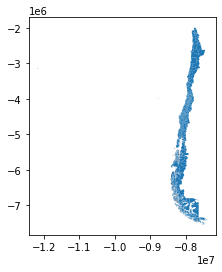

In [ ]:
comunas.plot()

No están haciendo bien el merge... que estará pasando?

In [ ]:
type(comunas['cod_comuna'][0])
codes1 = list()
for i in range(len(comunas['cod_comuna'])):
  codes1.append(comunas['cod_comuna'][i])

codes1.sort()

In [ ]:
codes2 = list()
for i in range(len(formap['cod_comuna'])):
  codes2.append(formap['cod_comuna'][i])


In [ ]:
print(codes1)
print(codes2)

[0, 1101, 1107, 1401, 1402, 1403, 1404, 1405, 2101, 2102, 2103, 2104, 2201, 2202, 2203, 2301, 2302, 3101, 3102, 3103, 3201, 3202, 3301, 3302, 3303, 3304, 4101, 4102, 4103, 4104, 4105, 4106, 4201, 4202, 4203, 4204, 4301, 4302, 4303, 4304, 4305, 5101, 5102, 5103, 5104, 5105, 5107, 5109, 5201, 5301, 5302, 5303, 5304, 5401, 5402, 5403, 5404, 5405, 5501, 5502, 5503, 5504, 5506, 5601, 5602, 5603, 5604, 5605, 5606, 5701, 5702, 5703, 5704, 5705, 5706, 5801, 5802, 5803, 5804, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6201, 6202, 6203, 6204, 6205, 6206, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7201, 7202, 7203, 7301, 7302, 7303, 7304, 7305, 7306, 7307, 7308, 7309, 7401, 7402, 7403, 7404, 7405, 7406, 7407, 7408, 8101, 8102, 8103, 8104, 8105, 8106, 8107, 8108, 8109, 8110, 8111, 8112, 8201, 8202, 8203, 8204, 8205, 8206, 8207, 8301, 8302, 8303, 8304, 8305, 8306, 

Procedemos a Mergear el GeoDataFrame con nuestra base de `formap`. Para ello usaremos el cod_comuna para hacer el merge. Antes convertimos los cod_comuna en formap en formato int y no string. De esta manera nos deshacemos de los 0 que anteponen algunos códigos de comunas.

In [ ]:
def make_int(value):
  return int(value)

formap['cod_comuna'] = formap['cod_comuna'].apply(make_int)

In [ ]:
mapita = comunas.merge(formap, how="left", on="cod_comuna")

In [ ]:
mapita = gpd.GeoDataFrame(mapita)

In [ ]:
mapita.head()

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry,35,37,38,39,40,41,42
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644....",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mapita.shape

(348, 19)

In [ ]:
mapita

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry,35,37,38,39,40,41,42
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644....",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,255,130240.555805,19,10,16305,16,8.751006e+08,160459.137929,Región de Ñuble,San Nicolás,Punilla,"POLYGON ((-8041950.854 -4349201.562, -8041735....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
344,253,311061.932415,19,10,16304,16,2.393007e+09,388109.613857,Región de Ñuble,San Fabián,Punilla,"POLYGON ((-7931328.549 -4363544.179, -7931320....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,245,159257.906431,19,10,16303,16,7.638173e+08,195593.933727,Región de Ñuble,Ñiquén,Punilla,"POLYGON ((-8026032.185 -4319505.012, -8025933....",0.0,0.0,0.0,0.0,1.0,0.0,0.0
346,243,157467.049667,19,10,16104,16,1.044405e+09,196962.664313,Región de Ñuble,El Carmen,Ñuble,"POLYGON ((-7986315.104 -4415272.935, -7986309....",0.0,0.0,0.0,1.0,0.0,0.0,1.0


Lista la Base de Datos en formato GeoDataFrame. Procedemos entonces a hacer los mapitas.

1. Mapita 1: 

In [ ]:
mapita.crs

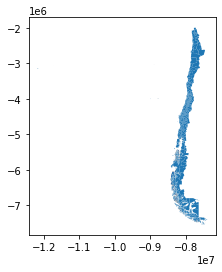

In [ ]:
mapita.plot()

In [ ]:
#pd.set_option('display.max_rows', None)

Botamos Isla de Pascua:

In [ ]:
mapita.drop(237)

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry,35,37,38,39,40,41,42
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644....",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,255,130240.555805,19,10,16305,16,8.751006e+08,160459.137929,Región de Ñuble,San Nicolás,Punilla,"POLYGON ((-8041950.854 -4349201.562, -8041735....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
344,253,311061.932415,19,10,16304,16,2.393007e+09,388109.613857,Región de Ñuble,San Fabián,Punilla,"POLYGON ((-7931328.549 -4363544.179, -7931320....",0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,245,159257.906431,19,10,16303,16,7.638173e+08,195593.933727,Región de Ñuble,Ñiquén,Punilla,"POLYGON ((-8026032.185 -4319505.012, -8025933....",0.0,0.0,0.0,0.0,1.0,0.0,0.0
346,243,157467.049667,19,10,16104,16,1.044405e+09,196962.664313,Región de Ñuble,El Carmen,Ñuble,"POLYGON ((-7986315.104 -4415272.935, -7986309....",0.0,0.0,0.0,1.0,0.0,0.0,1.0


Recordemos que:
1.   CAUSAS POR TRASTORNOS MENTALES (F00-F99) --> 41
2.   Ideación Suicida (R45.8) --> 39
3.   Lesiones autoinfligidas intencionalmente (X60-X84) --> 37
4.   Otros trastornos mentales no contenidos en las categorías anteriores --> 38
5. Trastornos del Humor (Afectivos) (F30-F39) --> 35
6. Trastornos mentales y del comportamiento debidos al uso de sustancias psicoactivas (F10-F19) --> 42
7. Trastornos neuróticos, trastornos relacionados con el estrés y trastornos somatomorfos (F40-F48) Incluído el trastorno de pánico (F41.0) --> 40

Para causa 41:

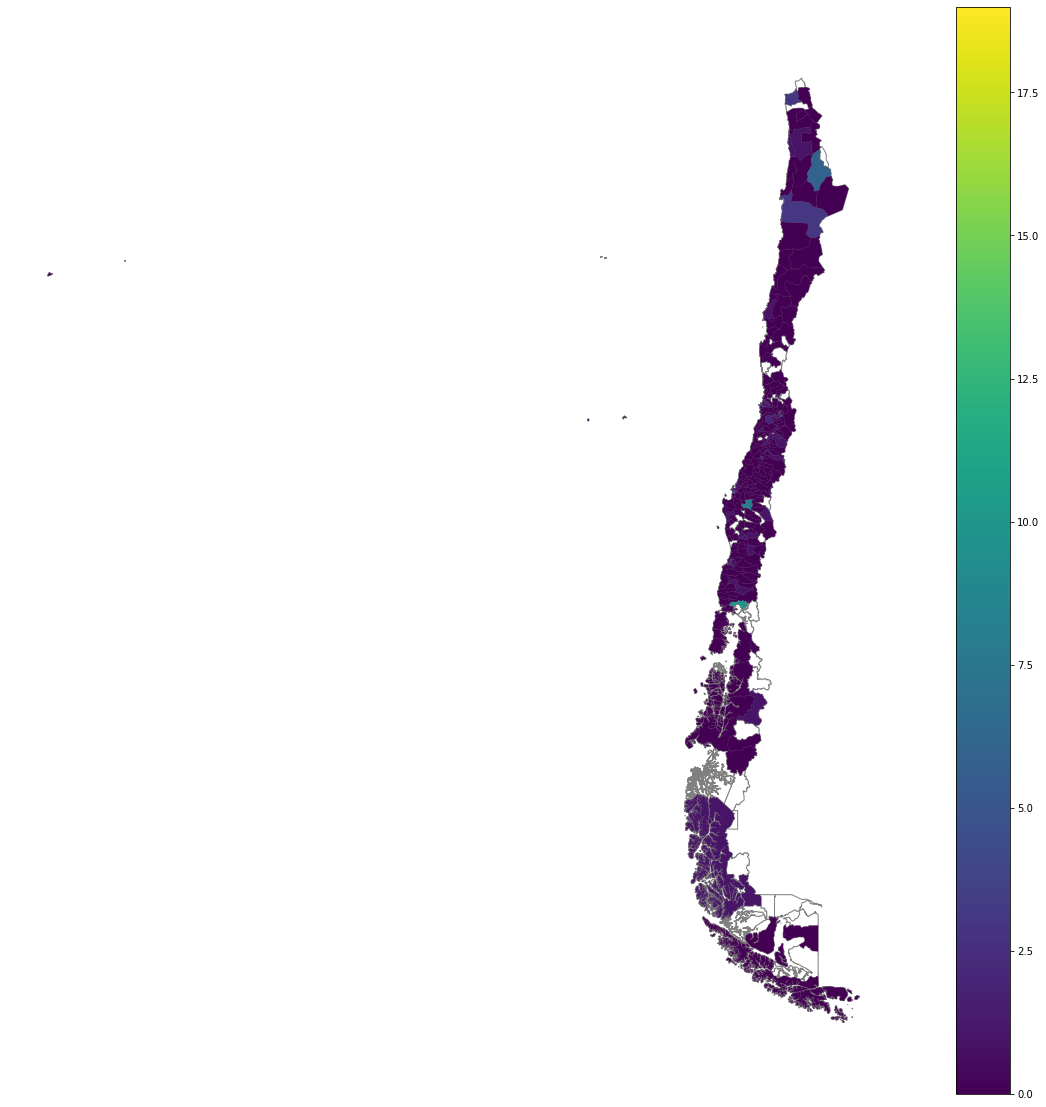

In [ ]:
import matplotlib.pyplot as plt
ax = mapita.plot(color = "white", edgecolor = "grey", figsize = (20,20))
fig = mapita.plot(ax = ax, column = 41 , legend = True)
plt.axis('off')
plt.show()

Para causa 39:

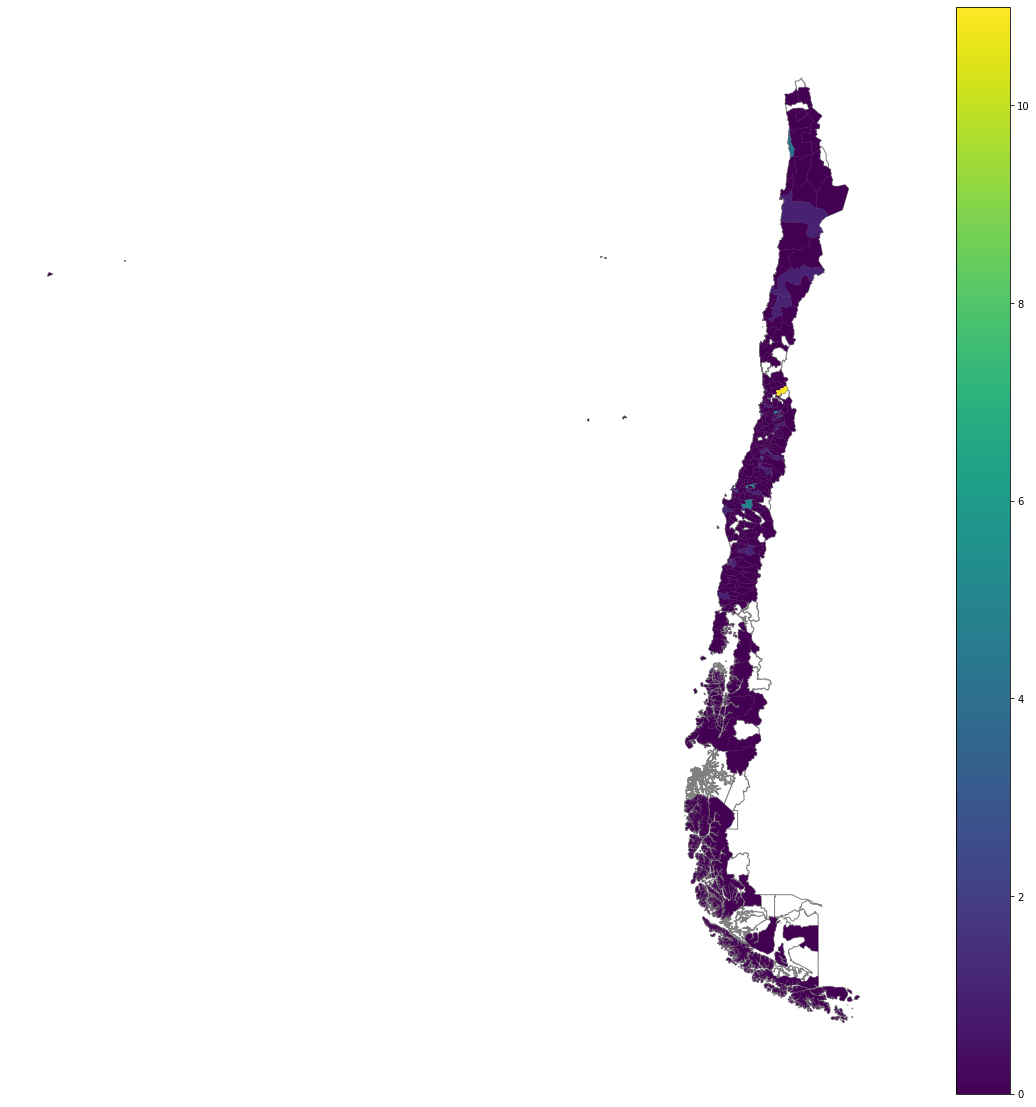

In [ ]:
import matplotlib.pyplot as plt
ax = mapita.plot(color = "white", edgecolor = "grey", figsize = (20,20))
fig = mapita.plot(ax = ax, column = 39 , legend = True)
plt.axis('off')
plt.show()

Para causa 37

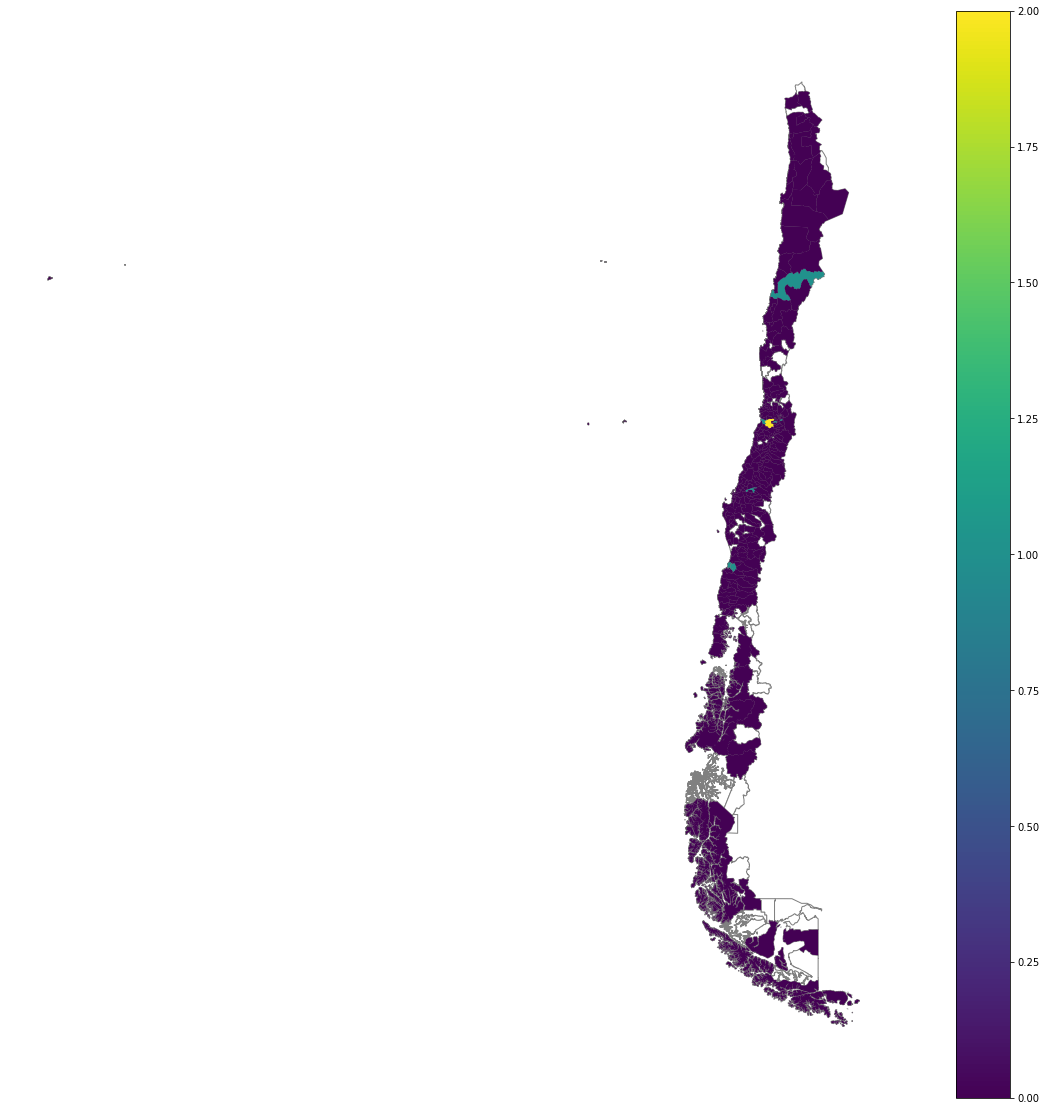

In [ ]:
import matplotlib.pyplot as plt
ax = mapita.plot(color = "white", edgecolor = "grey", figsize = (20,20))
fig = mapita.plot(ax = ax, column = 37 , legend = True)
plt.axis('off')
plt.show()

Para causa 38

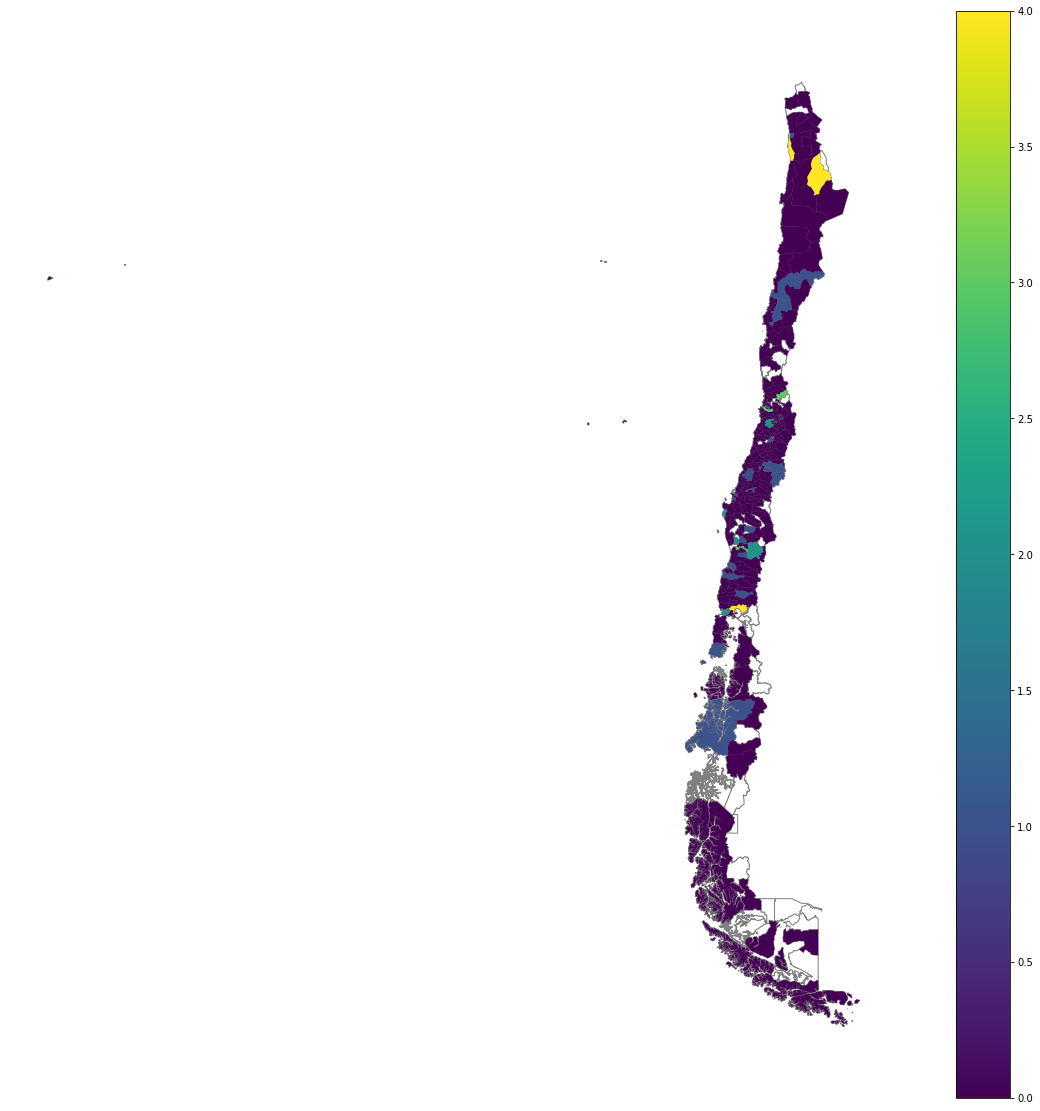

In [ ]:
import matplotlib.pyplot as plt
ax = mapita.plot(color = "white", edgecolor = "grey", figsize = (20,20))
fig = mapita.plot(ax = ax, column = 38 , legend = True)
plt.axis('off')
plt.show()

Para causa 35

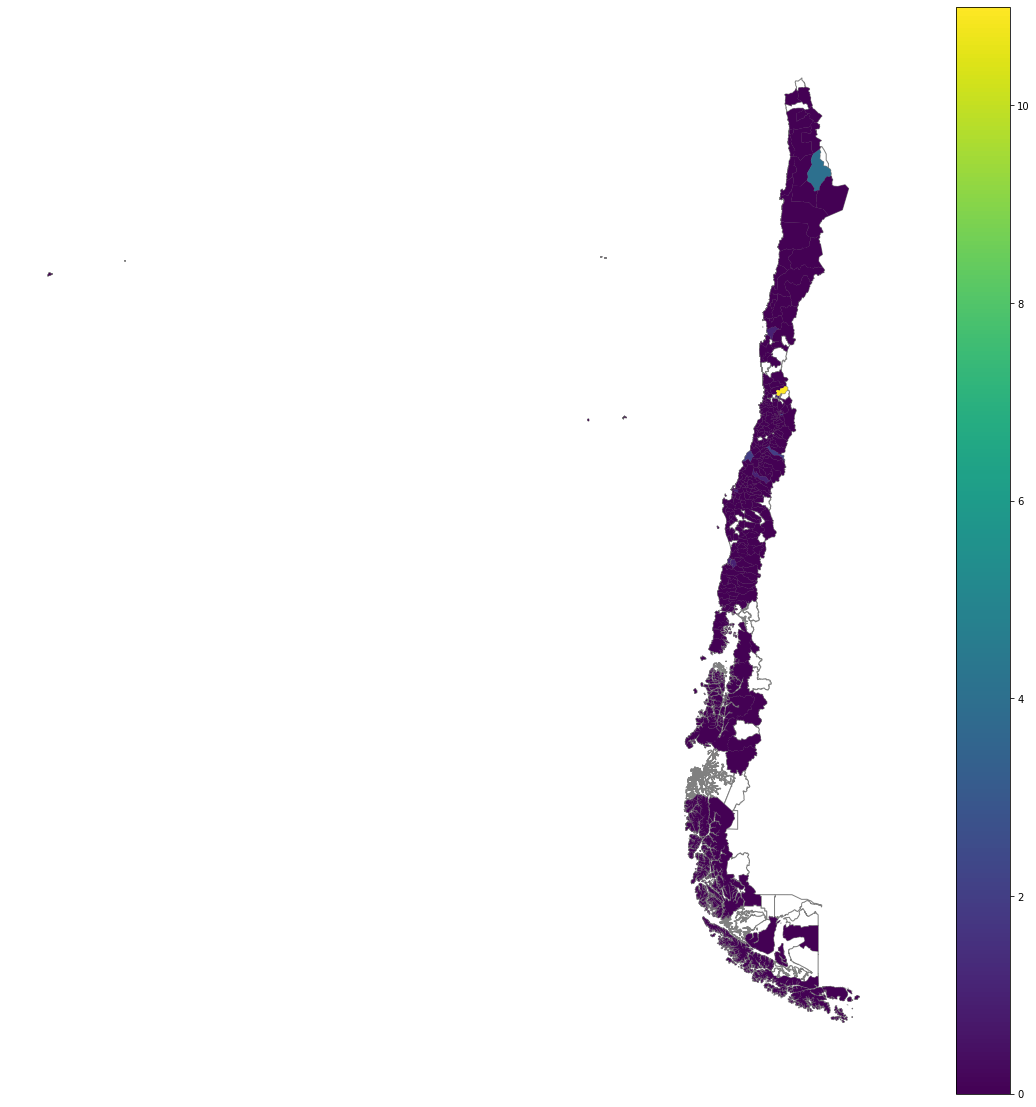

In [ ]:
import matplotlib.pyplot as plt
ax = mapita.plot(color = "white", edgecolor = "grey", figsize = (20,20))
fig = mapita.plot(ax = ax, column = 35 , legend = True)
plt.axis('off')
plt.show()

Para causa 42

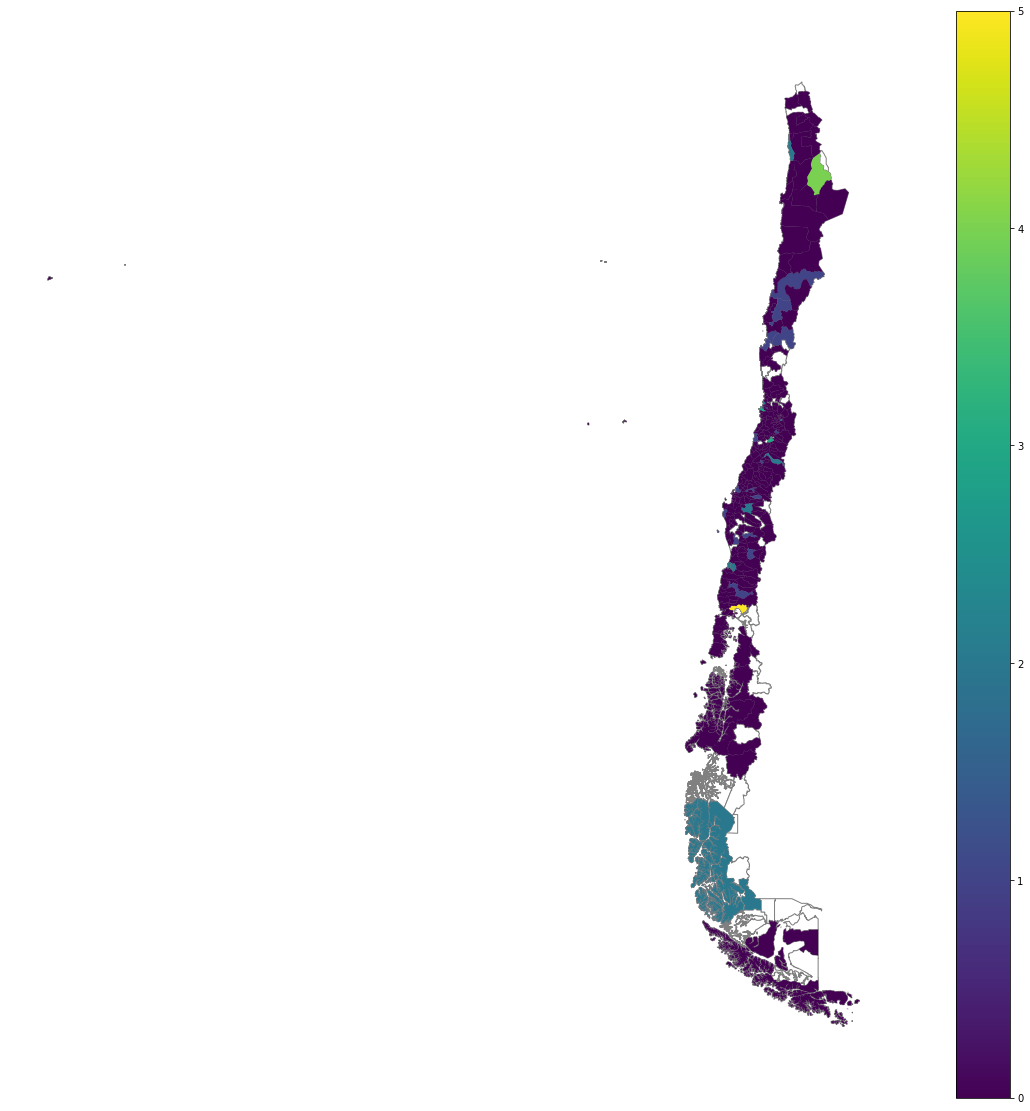

In [ ]:
import matplotlib.pyplot as plt
ax = mapita.plot(color = "white", edgecolor = "grey", figsize = (20,20))
fig = mapita.plot(ax = ax, column = 42 , legend = True)
plt.axis('off')
plt.show()

Para causa 40

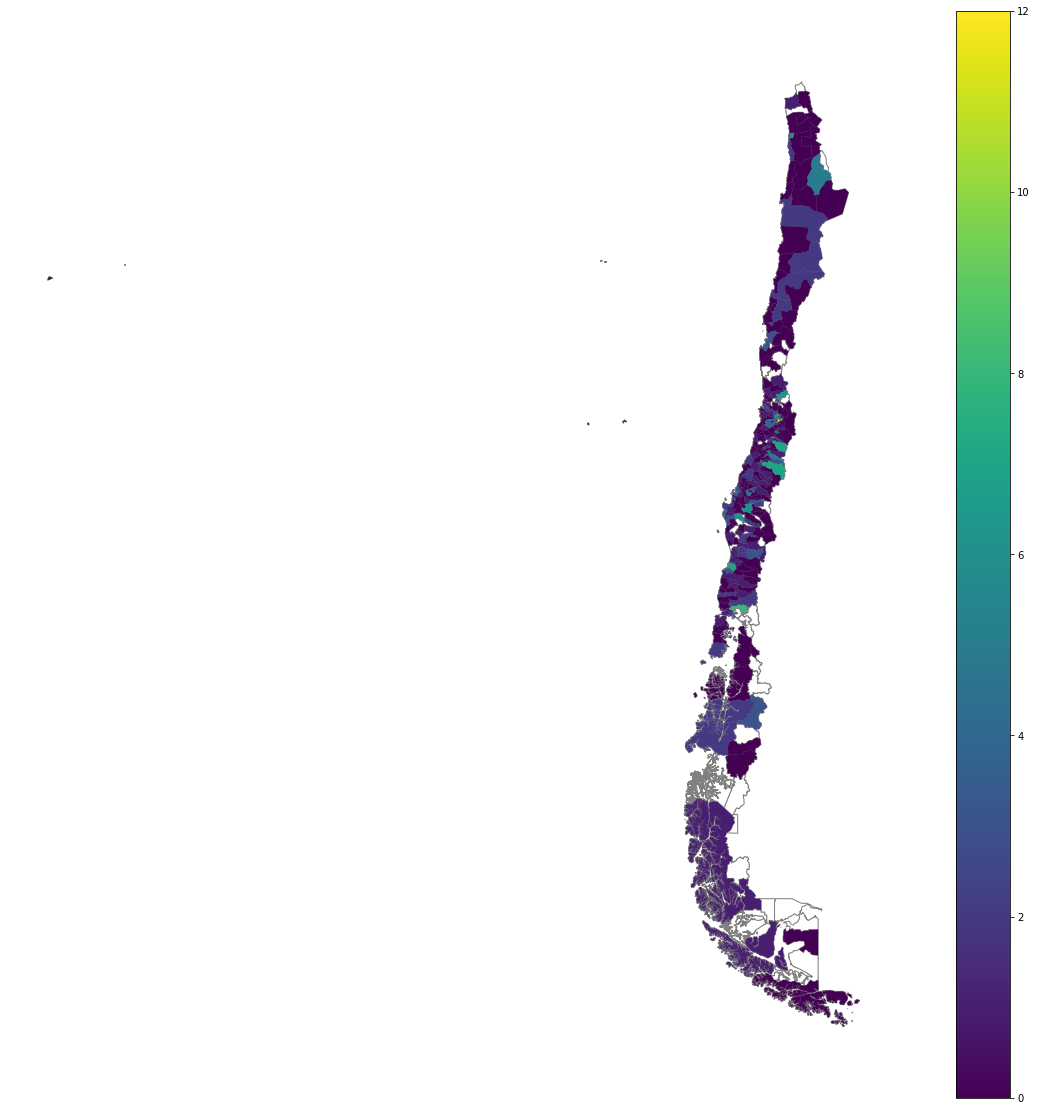

In [ ]:
import matplotlib.pyplot as plt
ax = mapita.plot(color = "white", edgecolor = "grey", figsize = (20,20))
fig = mapita.plot(ax = ax, column = 40 , legend = True)
plt.axis('off')
plt.show()

Ahora si creamos una columna que sume todas las demás: 

In [ ]:
ids

{35, 37, 38, 39, 40, 41, 42}

In [ ]:
mapita['suma'] = mapita[35] + mapita[37] + mapita[38] + mapita[39] + mapita[40] + mapita[41] + mapita[42]+1

Grafico para la Suma:

In [ ]:
from matplotlib.colors import LogNorm

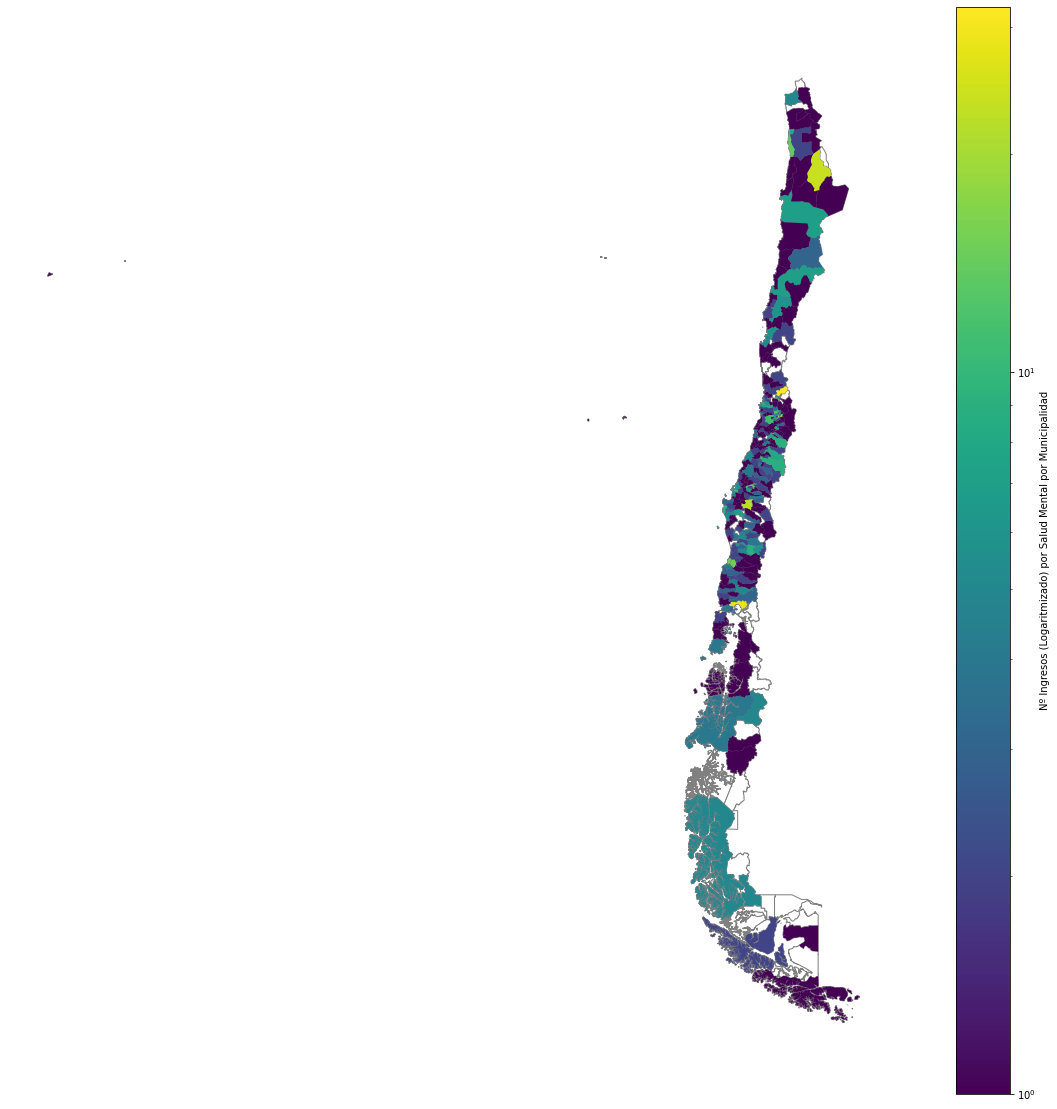

In [ ]:
import matplotlib.pyplot as plt
ax = mapita.plot(color = "white", edgecolor = "grey", figsize = (20,20))
fig = mapita.plot(ax = ax, column = 'suma' , legend = True, legend_kwds={'label': "Nº Ingresos (Logaritmizado) por Salud Mental por Municipalidad",'orientation': "vertical", "fmt": "{:1.0f}"}, norm=LogNorm(vmin=mapita.suma.min(), vmax=mapita.suma.max()))
plt.axis('off')
plt.show()

In [ ]:
mapita.head()

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry,35,37,38,39,40,41,42,comuna,suma
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731....",0.0,0.0,0.0,0.0,0.0,0.0,0.0,06204,0.0
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596....",0.0,0.0,0.0,0.0,0.0,0.0,0.0,06102,0.0
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621....",0.0,0.0,0.0,0.0,0.0,0.0,0.0,06103,0.0
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266....",0.0,0.0,0.0,0.0,0.0,0.0,0.0,06104,0.0
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Mapa con todos los Recintos Hospitalarios:

Quiero crear un mapita que contenga todos los recintos o establecimientos del país.

In [ ]:
hospitals2 = hospitals

In [ ]:
hospitals2['LATITUD      [Grados decimales]'] = hospitals2['LATITUD      [Grados decimales]'].replace(['Pendiente'],np.NaN)
hospitals2['LATITUD      [Grados decimales]'] = hospitals2['LATITUD      [Grados decimales]'].replace(['No Aplica'],np.NaN)

In [ ]:
hospitals2 = hospitals2.dropna(subset=['LATITUD      [Grados decimales]', 'LONGITUD [Grados decimales]'])

In [ ]:
gdf_hosp = gpd.GeoDataFrame(hospitals2, geometry=gpd.points_from_xy(hospitals2['LONGITUD [Grados decimales]'], hospitals2['LATITUD      [Grados decimales]']))

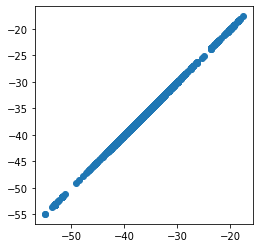

In [ ]:
gdf_hosp.plot()

Weird

## Análisis por Día (no por comuna)

In [ ]:
mental_health.pivot_table(index = 'dia', columns='glosacausa', aggfunc={'TOTAL':sum})

TOTAL  \
glosacausa  - CAUSAS POR TRASTORNOS MENTALES (F00-F99)   
dia                                                      
3                                                   31   
4                                                   54   
5                                                   50   
6                                                   48   
7                                                   58   
8                                                   47   
9                                                   23   

                                     \
glosacausa Ideación Suicida (R45.8)   
dia                                   
3                                20   
4                                11   
5                                28   
6                                16   
7                                17   
8                                17   
9                                15   

                                                               \
glosacausa Lesiones autoinfligidas intencionalmente (X60-X84)   
dia                                                             
3                                                          39   
4                                                          31   
5                                                          30   
6                                                          16   
7                                                          37   
8                                                          19   
9                                                          22   

                                                                                 \
glosacausa Otros trastornos mentales no contenidos en las categorías anteriores   
dia                                                                               
3                                                         134                     
4                                                         144                     
5                                                         159                     
6                                                         127                     
7                                                         129                     
8                                                         163                     
9                                                         130                     

                                                       \
glosacausa Trastornos del Humor (Afectivos) (F30-F39)   
dia                                                     
3                                                  47   
4                                                  86   
5                                                  77   
6                                                  61   
7                                                  63   
8                                                  52   
9                                                  38   

                                                                                                         \
glosacausa Trastornos mentales y del comportamiento debidos al uso de sustancias psicoactivas (F10-F19)   
dia                                                                                                       
3                                                         106                                             
4                                                          78                                             
5                                                          68                                             
6                                                          72                                             
7                                                          69                                             
8                                                          72                                             
9                                                          88

In [ ]:
#Mismo proceso para semana anterior!
semana_pre = data[data['semana'] == 39]
mental_health_pre = semana_pre[semana_pre['Idcausa'].isin(ids)]
mental_health_pre['dia'] = mental_health_pre['fecha'].apply(saca_dia)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#Ejecutamos misma tablita!
mental_health_pre.pivot_table(index = 'dia', columns='glosacausa', aggfunc={'TOTAL':sum})
#Fijarse en día 27

TOTAL  ...                                                                                                                                         
glosacausa  - CAUSAS POR TRASTORNOS MENTALES (F00-F99)  ... Trastornos neuróticos, trastornos relacionados con el estrés y trastornos somatomorfos (F40-F48) Incluído el trastorno de pánico (F41.0)
dia                                                     ...                                                                                                                                         
1                                                   44  ...                                                333                                                                                      
2                                                   33  ...                                                429                                                                                      
26                                                  42  ...                                                448                                                                                      
27                                                  55  ...                                                451                                                                                      
28                                                  45  ...                                                397                                                                                      
29                                                  58  ...                                                435                                                                                      
30                                                  45  ...                                                417                                                                                      

[7 rows x 8 columns]

In [ ]:
#Mismo proceso para semana posterior!
semana_post = data[data['semana'] == 41]
mental_health_post = semana_post[semana_post['Idcausa'].isin(ids)]
mental_health_post['dia'] = mental_health_post['fecha'].apply(saca_dia)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#Ejecutamos misma tablita!
mental_health_post.pivot_table(index = 'dia', columns='glosacausa', aggfunc={'TOTAL':sum})
#Fijarse en día 11

TOTAL  ...                                                                                                                                         
glosacausa  - CAUSAS POR TRASTORNOS MENTALES (F00-F99)  ... Trastornos neuróticos, trastornos relacionados con el estrés y trastornos somatomorfos (F40-F48) Incluído el trastorno de pánico (F41.0)
dia                                                     ...                                                                                                                                         
10                                                  31  ...                                                408                                                                                      
11                                                  35  ...                                                444                                                                                      
12                                                  54  ...                                                439                                                                                      
13                                                  49  ...                                                403                                                                                      
14                                                  43  ...                                                338                                                                                      
15                                                  53  ...                                                383                                                                                      
16                                                  32  ...                                                422                                                                                      

[7 rows x 8 columns]

In [ ]:
#Mismo proceso para primera semana del mes anterior!
semana_sept = data[data['semana'] == 36]
mental_health_sept = semana_sept[semana_sept['Idcausa'].isin(ids)]
mental_health_sept['dia'] = mental_health_sept['fecha'].apply(saca_dia)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
#Ejecutamos misma tablita!
mental_health_sept.pivot_table(index = 'dia', columns='glosacausa', aggfunc={'TOTAL':sum})
#Fijarse en día 6

TOTAL  ...                                                                                                                                         
glosacausa  - CAUSAS POR TRASTORNOS MENTALES (F00-F99)  ... Trastornos neuróticos, trastornos relacionados con el estrés y trastornos somatomorfos (F40-F48) Incluído el trastorno de pánico (F41.0)
dia                                                     ...                                                                                                                                         
5                                                   34  ...                                                388                                                                                      
6                                                   44  ...                                                405                                                                                      
7                                                   45  ...                                                349                                                                                      
8                                                   46  ...                                                385                                                                                      
9                                                   59  ...                                                382                                                                                      
10                                                  48  ...                                                385                                                                                      
11                                                  21  ...                                                345                                                                                      

[7 rows x 8 columns]

# Pytrends: Google Trends!

Probaremos los alcances de la API asociada a esta famosa página. La idea es sacar datos por hora de ciertas búsquedas que nos interesan!


In [ ]:
!pip install pytrends

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=e76b60229dd781d8d8285d0b8faea59b9e757137ff19d1490ed592e074812a3c
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends


In [ ]:
pip install --upgrade --user git+https://github.com/GeneralMills/pytrends

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/GeneralMills/pytrends to /tmp/pip-req-build-ltdxpuqg
  Running command git clone -q https://github.com/GeneralMills/pytrends /tmp/pip-req-build-ltdxpuqg
  Created wheel for pytrends: filename=pytrends-4.7.4-py3-none-any.whl size=16288 sha256=77bd4cc04e37de36ad310e556a7a6adf0f230c8fc9a3d053756d939a6adaf9d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-jk4_vsyj/wheels/c1/65/c5/60688c4521e16561ac09af949eb432957b257dfda14c4fe516
Successfully built pytrends


In [ ]:
import pytrends

In [ ]:
from pytrends.request import TrendReq

In [ ]:
pytrend = TrendReq(hl='en-US', tz=360)

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], geo = 'CL')
# Interest by Region
df = pytrend.interest_by_region(resolution='MUNICIPALITY', inc_low_vol=True, inc_geo_code=False)
df

,suicide
geoName,
Antofagasta Region,100
Araucania,67
Arica y Parinacota Region,83
Atacama Region,89
Bío Bío Region,71
Coquimbo Region,81
Los Lagos Region,75
Los Ríos Region,74
Magallanes y la Antártica Chilena Region,99


In [ ]:
kw_list = ['suicide', 'anxiety', 'depression', 'panic', 'rage']
#pytrend.build_payload(kw_list, cat=0, timeframe='2021-10-03 2021-10-09', geo='CL', gprop='')
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-GA')

Extraigo datos de 5 semanas: 2 semanas previas al apagón y dos posteriores al apagón. Partimos con Georgia:

In [ ]:
dataGA = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-GA')

In [ ]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

In [ ]:
dataGA['State'] = "GA"
dataGA['Timezone']=4

In [ ]:
dataGA

,suicide,anxiety,depression,panic,rage,isPartial,State,Timezone
date,,,,,,,,
2021-09-20 00:00:00,0,11,0,0,5,False,GA,4
2021-09-20 01:00:00,0,6,5,11,8,False,GA,4
2021-09-20 02:00:00,13,0,9,0,20,False,GA,4
2021-09-20 03:00:00,0,25,0,7,0,False,GA,4
2021-09-20 04:00:00,10,13,0,0,25,False,GA,4
...,...,...,...,...,...,...,...,...
2021-10-17 21:00:00,0,8,4,0,0,False,GA,4
2021-10-17 22:00:00,0,0,0,0,0,False,GA,4
2021-10-17 23:00:00,0,9,0,0,5,False,GA,4


In [ ]:
print(dataGA[dataGA['rage']==100])

                     suicide  anxiety  depression  panic  rage  isPartial  \
date                                                                        
2021-10-14 06:00:00        0        0          57      0   100      False   

                    State  Timezone  
date                                 
2021-10-14 06:00:00    GA         4  


Ahora con California:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-CA')
dataCA = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-CA')

In [ ]:
dataCA['State']="CA"
dataCA['Timezone']=1

In [ ]:
dataCA

,suicide,anxiety,depression,panic,rage,isPartial,State,Timezone
date,,,,,,,,
2021-09-20 00:00:00,10,11,5,0,0,False,CA,1
2021-09-20 01:00:00,8,7,6,8,3,False,CA,1
2021-09-20 02:00:00,7,17,8,0,5,False,CA,1
2021-09-20 03:00:00,23,13,14,5,0,False,CA,1
2021-09-20 04:00:00,12,11,11,3,0,False,CA,1
...,...,...,...,...,...,...,...,...
2021-10-17 21:00:00,19,6,11,5,4,False,CA,1
2021-10-17 22:00:00,4,8,14,0,0,False,CA,1
2021-10-17 23:00:00,4,5,5,7,5,False,CA,1


Ahora con Wyoming:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-WY')
dataWY = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-WY')

In [ ]:
dataWY['State']="WY"
dataWY['Timezone']=2

In [ ]:
dataWY

,suicide,anxiety,depression,panic,rage,isPartial,State,Timezone
date,,,,,,,,
2021-09-20 00:00:00,0,0,0,0,0,False,WY,2
2021-09-20 01:00:00,0,0,0,0,0,False,WY,2
2021-09-20 02:00:00,9,0,0,0,0,False,WY,2
2021-09-20 03:00:00,0,0,0,4,0,False,WY,2
2021-09-20 04:00:00,0,0,0,0,0,False,WY,2
...,...,...,...,...,...,...,...,...
2021-10-17 21:00:00,0,0,0,0,0,False,WY,2
2021-10-17 22:00:00,0,0,0,0,0,False,WY,2
2021-10-17 23:00:00,0,0,0,6,0,False,WY,2


Ahora con Texas

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-TX')
dataTX = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-TX')


In [ ]:
dataTX['State']="TX"
dataTX['Timezone']=3

In [ ]:
dataTX

,suicide,anxiety,depression,panic,rage,isPartial,State,Timezone
date,,,,,,,,
2021-09-20 00:00:00,0,8,5,8,0,False,TX,3
2021-09-20 01:00:00,10,8,4,0,0,False,TX,3
2021-09-20 02:00:00,18,18,6,7,0,False,TX,3
2021-09-20 03:00:00,12,11,13,9,0,False,TX,3
2021-09-20 04:00:00,15,8,15,0,0,False,TX,3
...,...,...,...,...,...,...,...,...
2021-10-17 21:00:00,10,7,14,0,0,False,TX,3
2021-10-17 22:00:00,4,10,0,5,3,False,TX,3
2021-10-17 23:00:00,10,5,6,0,7,False,TX,3


Ahora con Washington:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-WA')
dataWA = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-WA')

In [ ]:
dataWA['State']="WA"
dataWA['Timezone']=1

Ahora con Oregon:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-OR')
dataOR = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-OR')

In [ ]:
dataOR['State']="OR"
dataOR['Timezone']=1

Ahora con Montana:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-MT')
dataMT = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-MT')

In [ ]:
dataMT['State']="MT"
dataMT['Timezone']=2

Ahora con Illinois:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-IL')
dataIL = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-IL')

In [ ]:
dataIL['State']="IL"
dataIL['Timezone']=3

Ahora con New York:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-NY')
dataNY = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-NY')

In [ ]:
dataNY['State']="NY"
dataNY['Timezone']=4
dataNY.shape

(677, 8)

Ahora con Florida:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-FL')
dataFL = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-FL')

In [ ]:
dataFL['State']="FL"
dataFL['Timezone']=4

Ahora con Kansas:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-KS')
dataKS = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-KS')

In [ ]:
dataKS['State']="KS"
dataKS['Timezone']=3

Ahora con New Mexico:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-NM')
dataNM = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-NM')

In [ ]:
dataNM['State']="NM"
dataNM['Timezone']=2

Ahora con Minnesota:

In [ ]:
pytrend.build_payload(kw_list=['suicide', 'anxiety', 'depression', 'panic', 'rage'], timeframe='2021-09-20 2021-10-18', geo = 'US-MN')
dataMN = pytrend.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=20, hour_start=0, year_end=2021, month_end=10, day_end= 18, hour_end=0, geo = 'US-MN')

The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.


In [ ]:
dataMN['State']="MN"
dataMN['Timezone']=3

### JUNTAMOS BASES DE DATOS

In [ ]:
  trends = dataGA.append([dataCA,dataTX,dataWY,dataWA,dataOR,dataMT,dataIL,dataNY,dataFL,dataKS,dataNM])

In [ ]:
trends

,suicide,anxiety,depression,panic,rage,isPartial,State,Timezone
date,,,,,,,,
2021-09-20 00:00:00,0,20,0,5,5,False,GA,4
2021-09-20 01:00:00,14,13,7,0,0,False,GA,4
2021-09-20 02:00:00,0,28,10,0,13,False,GA,4
2021-09-20 03:00:00,0,13,26,0,0,False,GA,4
2021-09-20 04:00:00,15,0,0,0,0,False,GA,4
...,...,...,...,...,...,...,...,...
2021-10-17 21:00:00,0,0,0,0,0,False,NM,2
2021-10-17 22:00:00,0,0,0,0,0,False,NM,2
2021-10-17 23:00:00,0,11,0,0,0,False,NM,2


In [ ]:
trends['date'] = trends.index

In [ ]:
def saca_dia(datetime):
  '''Saca día de datetime'''
  dia = datetime.day
  return dia
  
def saca_mes(datetime):
  '''Saca mes de datetime'''
  mes = datetime.month
  return mes

def saca_hora(datetime):
  '''Saca hora de datetime'''
  hora = datetime.hour
  return hora

In [ ]:
trends['day'] = trends['date'].apply(saca_dia)
trends['month'] = trends['date'].apply(saca_mes)
trends['hour'] = trends['date'].apply(saca_hora)

In [ ]:
compression_opts = dict(method='zip', archive_name='trends.csv')
trends.to_csv('trends.zip', index=False, compression=compression_opts)

In [ ]:
trends

,suicide,anxiety,depression,panic,rage,isPartial,State,Timezone,date,day,month,hour
date,,,,,,,,,,,,
2021-09-20 00:00:00,0,20,0,5,5,False,GA,4,2021-09-20 00:00:00,20,9,0
2021-09-20 01:00:00,14,13,7,0,0,False,GA,4,2021-09-20 01:00:00,20,9,1
2021-09-20 02:00:00,0,28,10,0,13,False,GA,4,2021-09-20 02:00:00,20,9,2
2021-09-20 03:00:00,0,13,26,0,0,False,GA,4,2021-09-20 03:00:00,20,9,3
2021-09-20 04:00:00,15,0,0,0,0,False,GA,4,2021-09-20 04:00:00,20,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-17 21:00:00,9,7,0,4,9,False,FL,4,2021-10-17 21:00:00,17,10,21
2021-10-17 22:00:00,10,3,0,0,0,False,FL,4,2021-10-17 22:00:00,17,10,22
2021-10-17 23:00:00,15,0,0,4,0,False,FL,4,2021-10-17 23:00:00,17,10,23


In [ ]:
trends1 = pd.read_csv('/content/gdrive/MyDrive/Universidad/Tesis/trends_2.csv')
trends2 = pd.read_csv('/content/gdrive/MyDrive/Universidad/Tesis/trends_S.csv')

In [ ]:
trends1

,suicide,anxiety,depression,panic,rage,isPartial,State,Timezone,date,day,month,hour
0,0,20,0,5,5,False,GA,4,2021-09-20 00:00:00,20,9,0
1,14,13,7,0,0,False,GA,4,2021-09-20 01:00:00,20,9,1
2,0,28,10,0,13,False,GA,4,2021-09-20 02:00:00,20,9,2
3,0,13,26,0,0,False,GA,4,2021-09-20 03:00:00,20,9,3
4,15,0,0,0,0,False,GA,4,2021-09-20 04:00:00,20,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,0,0,0,False,NM,2,2021-10-17 21:00:00,17,10,21
8120,0,0,0,0,0,False,NM,2,2021-10-17 22:00:00,17,10,22
8121,0,11,0,0,0,False,NM,2,2021-10-17 23:00:00,17,10,23
8122,0,0,0,7,13,False,NM,2,2021-10-18 00:00:00,18,10,0


In [ ]:
trends2

,suicide,anxiety,depression,panic,rage,isPartial,State,Timezone,date,day,month,hour
0,0,0,0,0,0,False,MN,3.0,2021-09-20 00:00:00,20,9,0
1,3,0,4,4,0,False,MN,3.0,2021-09-20 01:00:00,20,9,1
2,0,9,0,0,0,False,MN,3.0,2021-09-20 02:00:00,20,9,2
3,8,8,9,0,0,False,MN,3.0,2021-09-20 03:00:00,20,9,3
4,0,0,0,0,8,False,MN,3.0,2021-09-20 04:00:00,20,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...
25044,0,0,0,0,0,False,DC,4.0,2021-10-17 21:00:00,17,10,21
25045,0,0,7,0,0,False,DC,4.0,2021-10-17 22:00:00,17,10,22
25046,0,0,0,0,0,False,DC,4.0,2021-10-17 23:00:00,17,10,23
25047,5,0,0,0,0,False,DC,4.0,2021-10-18 00:00:00,18,10,0


In [ ]:
trendsF = trends1.append(trends2)

In [ ]:
trendsF

,suicide,anxiety,depression,panic,rage,isPartial,State,Timezone,date,day,month,hour
0,0,20,0,5,5,False,GA,4.0,2021-09-20 00:00:00,20,9,0
1,14,13,7,0,0,False,GA,4.0,2021-09-20 01:00:00,20,9,1
2,0,28,10,0,13,False,GA,4.0,2021-09-20 02:00:00,20,9,2
3,0,13,26,0,0,False,GA,4.0,2021-09-20 03:00:00,20,9,3
4,15,0,0,0,0,False,GA,4.0,2021-09-20 04:00:00,20,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...
25044,0,0,0,0,0,False,DC,4.0,2021-10-17 21:00:00,17,10,21
25045,0,0,7,0,0,False,DC,4.0,2021-10-17 22:00:00,17,10,22
25046,0,0,0,0,0,False,DC,4.0,2021-10-17 23:00:00,17,10,23
25047,5,0,0,0,0,False,DC,4.0,2021-10-18 00:00:00,18,10,0


In [ ]:
compression_opts = dict(method='zip', archive_name='trendsF.csv')
trendsF.to_csv('trendsF.zip', index=False, compression=compression_opts)

## Mortality Data

In [ ]:
deaths = pd.read_csv('/content/gdrive/MyDrive/Universidad/Tesis/DEFUNCIONES_FUENTE_DEIS_2016_2022_11082022.csv', sep = ';', encoding='latin-1')

In [ ]:
deaths.tail()

,ï»¿2022,2022-02-15,Mujer,1,89,13111,La Granja,Metropolitana de Santiago,F03X,F00-F99,Trastornos mentales y del comportamiento,F00-F09,"Trastornos mentales orgÃ¡nicos, incluidos los trastornos sintomÃ¡ticos",F03,"Demencia , no especificada",F03X.1,DEMENCIA NO ESPECIFICADA,Unnamed: 17,NULL,NULL.1,NULL.2,NULL.3,NULL.4,NULL.5,NULL.6,NULL.7,Casa habitaciÃ³n
775584,2016,2016-08-28,Mujer,1,74,10103,CochamÃ³,De Los Lagos,E119,E00-E90,"Enfermedades endocrinas, nutricionales y metab...",E10-E14,Diabetes mellitus,E11,Diabetes mellitus no insulinodependiente,E119,DIABETES MELLITUS NO INSULINODEPENDIENTE SIN M...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Otro
775585,2016,2016-08-30,Mujer,1,86,10209,Quemchi,De Los Lagos,J449,J00-J99,Enfermedades del sistema respiratorio,J40-J47,Enfermedades crÃ³nicas de las vÃ­as respirator...,J44,Otras enfermedades pulmonares obstructivas crÃ...,J449,ENFERMEDAD PULMÃNAR OBSTRUCTIVA CRONICA NO ES...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospital o ClÃ­nica
775586,2016,2016-08-26,Hombre,1,84,10205,Dalcahue,De Los Lagos,C61X,C00-D48,Tumores [Neoplasias],C60-C63,Tumores malignos de los Ã³rganos genitales mas...,C61,Tumor maligno de la prÃ³stata,C61X,TUMOR MALIGNO DE LA PRÃSTATA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Casa habitaciÃ³n
775587,2016,2016-09-02,Mujer,1,90,10205,Dalcahue,De Los Lagos,J459,J00-J99,Enfermedades del sistema respiratorio,J40-J47,Enfermedades crÃ³nicas de las vÃ­as respirator...,J45,Asma,J459,ASMA NO ESPECIFICADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Casa habitaciÃ³n
775588,2016,2016-08-26,Hombre,1,53,10201,Castro,De Los Lagos,S069,S00-T98,"Traumatismos, envenenamientos y algunas otras ...",S00-S09,Traumatismos de la cabeza,S06,Traumatismo intracraneal,S069,TRAUMATISMO INTRACRANEAL NO ESPECIFICADO,W179,V01-Y98,Causas externas de morbilidad y de mortalidad,W00-W19,CaÃ­das,W17,Otras caÃ­das de un nivel a otro,W179,OTRA CAÃDA DESDE UN NIVEL A OTRO OCURRIDA EN ...,Hospital o ClÃ­nica


# Revisando Shapefile de Condados para Institucional!

In [ ]:
!pip3 install geopandas

     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 15.4 MB 29.8 MB/s 
     |████████████████████████████████| 6.3 MB 16.7 MB/s 


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np

El siguiente es el que va!!

In [ ]:
condados = gpd.read_file("/content/cb_2018_us_county_500k.shp")

In [ ]:
condados
# El que me importa como ID para mergear es el GEOID.

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."
...,...,...,...,...,...,...,...,...,...,...
3228,31,073,00835858,0500000US31073,31073,Gosper,06,1186616237,11831826,"POLYGON ((-100.09510 40.43866, -100.08937 40.4..."
3229,39,075,01074050,0500000US39075,39075,Holmes,06,1094405866,3695230,"POLYGON ((-82.22066 40.66758, -82.19327 40.667..."
3230,48,171,01383871,0500000US48171,48171,Gillespie,06,2740719114,9012764,"POLYGON ((-99.30400 30.49983, -99.28234 30.499..."
3231,55,079,01581100,0500000US55079,55079,Milwaukee,06,625440563,2455383635,"POLYGON ((-88.06959 42.86726, -88.06959 42.872..."


In [ ]:
condados.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [ ]:
condados = condados.to_crs(4326)

In [ ]:
condados.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Siguiendo lo realizado en L05 (Actividad 2.B) crearé un diccionario con todos los GEOID y sus respectivos polígonos.

In [ ]:
revisar = condados[['GEOID', 'geometry']]

In [ ]:
diccio = {}
for i in range(len(revisar)):
  diccio[revisar.iloc[i, 0]] = revisar.iloc[i, 1]

print(diccio)

{'21007': <shapely.geometry.polygon.Polygon object at 0x7f2872f81d50>, '21017': <shapely.geometry.polygon.Polygon object at 0x7f2872f81550>, '21031': <shapely.geometry.polygon.Polygon object at 0x7f2872f813d0>, '21065': <shapely.geometry.polygon.Polygon object at 0x7f2872f81650>, '21069': <shapely.geometry.polygon.Polygon object at 0x7f2872f81ed0>, '21093': <shapely.geometry.polygon.Polygon object at 0x7f2872f81110>, '21099': <shapely.geometry.polygon.Polygon object at 0x7f2872f81210>, '21131': <shapely.geometry.polygon.Polygon object at 0x7f2872f6c150>, '21151': <shapely.geometry.polygon.Polygon object at 0x7f2872f6c750>, '21155': <shapely.geometry.polygon.Polygon object at 0x7f2872f6c2d0>, '21179': <shapely.geometry.polygon.Polygon object at 0x7f2872f6c0d0>, '17091': <shapely.geometry.polygon.Polygon object at 0x7f2872f6c550>, '17187': <shapely.geometry.polygon.Polygon object at 0x7f2872f6c110>, '17197': <shapely.geometry.polygon.Polygon object at 0x7f2872f6cd90>, '18027': <shapely.g

In [ ]:
len(diccio)
# Perfesto!

3233

## Importo Random Long-Lat y hago que coordenadas sean punto!

In [ ]:
sxsw = pd.read_csv('f2017.csv')

In [ ]:
sxsw.head()

,Unnamed: 0,Unnamed: 0.1,created_at,id,username,name,location,spliteado,año,mes,author_long_lat
0,87,159,2007-02-08T21:06:34.000Z,758697,rob_jonas,Rob Jonas,"Los Angeles, CA","['2007', '02', '08T21:06:34.000Z']",2007,2,"[-118.2439, 34.0544]"
1,237,405,2007-12-31T19:06:11.000Z,11696422,rudeboy7969,Mark J,Little Rock Arkansas,"['2007', '12', '31T19:06:11.000Z']",2007,12,"[-92.2896, 34.7465]"
2,546,944,2007-08-07T07:44:49.000Z,8015912,hdknr,Mew Roy aka ネコビト,"Magic City, Atlanta","['2007', '08', '07T07:44:49.000Z']",2007,8,"[-84.397367, 33.748304]"
3,887,1630,2007-03-26T21:47:58.000Z,2363741,knyt,knut s. tungland,"Jørpeland,norway","['2007', '03', '26T21:47:58.000Z']",2007,3,"[6.05, 59.01667]"
4,959,1759,2007-07-16T20:00:17.000Z,7514892,veresk24,Heather,Canberra,"['2007', '07', '16T20:00:17.000Z']",2007,7,"[149.1289, -35.2819]"


In [ ]:
sxsw['author_long_lat'][0]

'[-118.2439, 34.0544]'

In [ ]:
import ast

In [ ]:
def tolist(string):
  x = ast.literal_eval(string)
  return x

In [ ]:
sxsw['author_long_lat'] = sxsw['author_long_lat'].apply(tolist)

In [ ]:
random.head()

,Unnamed: 0,Unnamed: 0.1,author_id,id,text,created_at,author_info,author_location,author_long_lat
0,137,174,948894055,684812870329221121,Swear to GAWD my hero @mikepiazza31 better get...,2016-01-06T19:04:46.000Z,"{'name': 'mike 🎄', 'username': 'mstacey9', 'lo...","Philadelphia, PA","[-75.1327, 40.0115]"
1,1228,1590,992164392,674704293530849280,This will be me if my friend and I get upgrade...,2015-12-09T21:36:53.000Z,"{'created_at': '2012-12-06T01:43:46.000Z', 'id...","Delaware, USA","[-75.5055627423557, 38.9978781537]"
2,1875,2366,335859336,684812322729259008,Noche de Reyes #Roscón2016 🌠🐫🐫🐫 @ Roscon de Re...,2016-01-06T19:02:35.000Z,"{'location': 'Mula (Murcia)', 'created_at': '2...",Mula (Murcia),"[-1.49069, 38.04187]"
3,5138,6471,37503584,684811335587123201,It's crazy how much better I feel mentally whe...,2016-01-06T18:58:40.000Z,"{'location': 'Overland Park, KS', 'name': 'Gol...","Overland Park, KS","[-94.6708, 38.9822]"
4,2484,3232,1700140386,674703910821429248,@raven_sparkles isn't this yours or am I tripp...,2015-12-09T21:35:22.000Z,"{'location': 'Texas, USA', 'id': '1700140386',...","Texas, USA","[-98.8223185136653, 31.8039734986]"


In [ ]:
sxsw['author_long_lat'][0]

[-118.2439, 34.0544]

In [ ]:
def extrae_0(lista):
  return lista[0]

In [ ]:
def extrae_1(lista):
  return lista[1]

In [ ]:
sxsw['x'] = sxsw['author_long_lat'].apply(extrae_0)

In [ ]:
sxsw['y'] = sxsw['author_long_lat'].apply(extrae_1)

In [ ]:
sxsw.head()

,Unnamed: 0,Unnamed: 0.1,created_at,id,username,name,location,spliteado,año,mes,author_long_lat,x,y
0,87,159,2007-02-08T21:06:34.000Z,758697,rob_jonas,Rob Jonas,"Los Angeles, CA","['2007', '02', '08T21:06:34.000Z']",2007,2,"[-118.2439, 34.0544]",-118.243900,34.054400
1,237,405,2007-12-31T19:06:11.000Z,11696422,rudeboy7969,Mark J,Little Rock Arkansas,"['2007', '12', '31T19:06:11.000Z']",2007,12,"[-92.2896, 34.7465]",-92.289600,34.746500
2,546,944,2007-08-07T07:44:49.000Z,8015912,hdknr,Mew Roy aka ネコビト,"Magic City, Atlanta","['2007', '08', '07T07:44:49.000Z']",2007,8,"[-84.397367, 33.748304]",-84.397367,33.748304
3,887,1630,2007-03-26T21:47:58.000Z,2363741,knyt,knut s. tungland,"Jørpeland,norway","['2007', '03', '26T21:47:58.000Z']",2007,3,"[6.05, 59.01667]",6.050000,59.016670
4,959,1759,2007-07-16T20:00:17.000Z,7514892,veresk24,Heather,Canberra,"['2007', '07', '16T20:00:17.000Z']",2007,7,"[149.1289, -35.2819]",149.128900,-35.281900


In [ ]:
sxsw_geo = gpd.GeoDataFrame(sxsw, geometry=gpd.points_from_xy(sxsw['x'], sxsw['y'], crs="EPSG:4326"))

In [ ]:
sxsw_geo.head()

,Unnamed: 0,Unnamed: 0.1,created_at,id,username,name,location,spliteado,año,mes,author_long_lat,x,y,geometry
0,87,159,2007-02-08T21:06:34.000Z,758697,rob_jonas,Rob Jonas,"Los Angeles, CA","['2007', '02', '08T21:06:34.000Z']",2007,2,"[-118.2439, 34.0544]",-118.243900,34.054400,POINT (-118.24390 34.05440)
1,237,405,2007-12-31T19:06:11.000Z,11696422,rudeboy7969,Mark J,Little Rock Arkansas,"['2007', '12', '31T19:06:11.000Z']",2007,12,"[-92.2896, 34.7465]",-92.289600,34.746500,POINT (-92.28960 34.74650)
2,546,944,2007-08-07T07:44:49.000Z,8015912,hdknr,Mew Roy aka ネコビト,"Magic City, Atlanta","['2007', '08', '07T07:44:49.000Z']",2007,8,"[-84.397367, 33.748304]",-84.397367,33.748304,POINT (-84.39737 33.74830)
3,887,1630,2007-03-26T21:47:58.000Z,2363741,knyt,knut s. tungland,"Jørpeland,norway","['2007', '03', '26T21:47:58.000Z']",2007,3,"[6.05, 59.01667]",6.050000,59.016670,POINT (6.05000 59.01667)
4,959,1759,2007-07-16T20:00:17.000Z,7514892,veresk24,Heather,Canberra,"['2007', '07', '16T20:00:17.000Z']",2007,7,"[149.1289, -35.2819]",149.128900,-35.281900,POINT (149.12890 -35.28190)


Ahora que tenemos cada tweet geo-referenciado podemos ahora asignar a cada Condado!

In [ ]:
def encontrar_county(tweet, dfcounty = diccio):
  for id in dfcounty.keys():
    if tweet.touches(dfcounty[id]) or tweet.within(dfcounty[id]):
      return int(id)
    else:
      return np.nan

In [ ]:
sxsw_geo['geoid'] = np.nan

In [ ]:
for i in range(len(sxsw_geo)):
  for id in diccio.keys():
    try:
      if sxsw_geo.loc[i,'geometry'].within(diccio[id]) or sxsw_geo.loc[i,'geometry'].touches(diccio[id]):
        sxsw_geo.loc[i,'geoid'] = id
    except:
      continue
  

In [ ]:
for id in diccio.keys():
  if random_geo.loc[1,'geometry'].within(diccio[id]) or random_geo.loc[1,'geometry'].touches(diccio[id]):
    print(id)


10001


In [ ]:
sxsw_geo.to_csv('sxswgeo.csv')

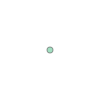

In [ ]:
random_geo.loc[0,'geometry']

In [ ]:
condados.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
random_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
import matplotlib.pyplot as plt

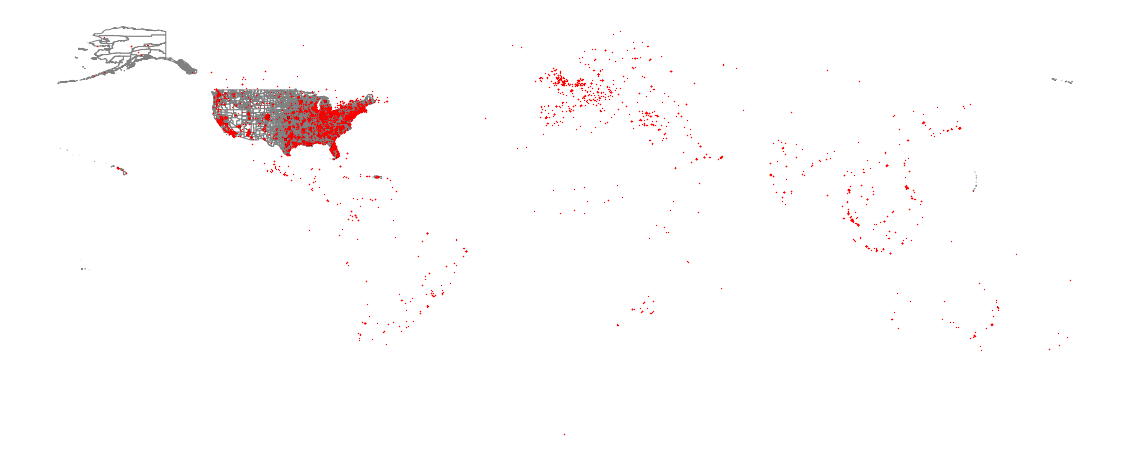

In [ ]:
ax = condados.plot(color = "white", edgecolor = "grey",figsize=(20,20))
random_geo.plot(ax = ax, color = "red", markersize= 0.1, marker = 'x')
plt.axis('off')
plt.show()

In [ ]:
sxsw_geo

,Unnamed: 0,Unnamed: 0.1,created_at,id,username,name,location,spliteado,año,mes,author_long_lat,x,y,geometry,geoid
0,87,159,2007-02-08T21:06:34.000Z,758697,rob_jonas,Rob Jonas,"Los Angeles, CA","['2007', '02', '08T21:06:34.000Z']",2007,2,"[-118.2439, 34.0544]",-118.243900,34.054400,POINT (-118.24390 34.05440),06037
1,237,405,2007-12-31T19:06:11.000Z,11696422,rudeboy7969,Mark J,Little Rock Arkansas,"['2007', '12', '31T19:06:11.000Z']",2007,12,"[-92.2896, 34.7465]",-92.289600,34.746500,POINT (-92.28960 34.74650),05119
2,546,944,2007-08-07T07:44:49.000Z,8015912,hdknr,Mew Roy aka ネコビト,"Magic City, Atlanta","['2007', '08', '07T07:44:49.000Z']",2007,8,"[-84.397367, 33.748304]",-84.397367,33.748304,POINT (-84.39737 33.74830),13121
3,887,1630,2007-03-26T21:47:58.000Z,2363741,knyt,knut s. tungland,"Jørpeland,norway","['2007', '03', '26T21:47:58.000Z']",2007,3,"[6.05, 59.01667]",6.050000,59.016670,POINT (6.05000 59.01667),NaN
4,959,1759,2007-07-16T20:00:17.000Z,7514892,veresk24,Heather,Canberra,"['2007', '07', '16T20:00:17.000Z']",2007,7,"[149.1289, -35.2819]",149.128900,-35.281900,POINT (149.12890 -35.28190),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,8154,13145,2007-10-05T01:39:53.000Z,9255772,sharonhoffman,Sharon Hoffman,Los Angeles,"['2007', '10', '05T01:39:53.000Z']",2007,10,"[-118.2439, 34.0544]",-118.243900,34.054400,POINT (-118.24390 34.05440),06037
97,8266,13310,2007-04-03T16:42:16.000Z,3338681,eekabeep,Theresa,"Austin, TX","['2007', '04', '03T16:42:16.000Z']",2007,4,"[-97.7437, 30.2711]",-97.743700,30.271100,POINT (-97.74370 30.27110),48453
98,8531,13711,2007-08-25T17:55:39.000Z,8428902,secunda,Andrew Secunda,Mordor,"['2007', '08', '25T17:55:39.000Z']",2007,8,"[-58.524755, -34.638701]",-58.524755,-34.638701,POINT (-58.52475 -34.63870),NaN
99,8600,13836,2007-01-11T13:33:27.000Z,625593,rgangstad,Raymond Gangstad,Oslo,"['2007', '01', '11T13:33:27.000Z']",2007,1,"[10.814466, 59.855058]",10.814466,59.855058,POINT (10.81447 59.85506),NaN


Boto todos los que ponen ubicación United States... Solo 192!

In [ ]:
sxsw_geo.drop(sxsw_geo[sxsw_geo['location']=='United States'].index , inplace=True)

In [ ]:
sxsw_geo.shape

(101, 15)

In [ ]:
sxsw_geo.to_csv('sxsw.csv')

In [ ]:
sxsw_geo.dropna(inplace=True)

In [ ]:
sxsw_geo.shape

(57, 15)

In [ ]:
random_geo.to_csv('randomgeoclean.csv')

In [ ]:
mergear1 = sxsw_geo.groupby('geoid').count()

In [ ]:
mergear1

,Unnamed: 0,Unnamed: 0.1,created_at,id,username,name,location,spliteado,año,mes,author_long_lat,x,y,geometry
geoid,,,,,,,,,,,,,,
05119,1,1,1,1,1,1,1,1,1,1,1,1,1,1
06013,1,1,1,1,1,1,1,1,1,1,1,1,1,1
06037,7,7,7,7,7,7,7,7,7,7,7,7,7,7
06039,2,2,2,2,2,2,2,2,2,2,2,2,2,2
06073,1,1,1,1,1,1,1,1,1,1,1,1,1,1
06075,1,1,1,1,1,1,1,1,1,1,1,1,1,1
08031,1,1,1,1,1,1,1,1,1,1,1,1,1,1
11001,1,1,1,1,1,1,1,1,1,1,1,1,1,1
12001,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
lista = []
for i in diccio.keys():
  lista.append(i)

lista.sort()

print(len(lista))

3233


In [ ]:
merge = mergear1[['geometry']]

In [ ]:
merge['GEOID'] = merge.index

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
merge.reset_index(drop=True)

,geometry,GEOID
0,1,05119
1,1,06013
2,7,06037
3,2,06039
4,1,06073
5,1,06075
6,1,08031
7,1,11001
8,1,12001
9,1,12057


In [ ]:
merge.to_csv('sxswstata.csv')